Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3633 - Sistemas Recomendadores
<br>

<center>
    <h2> Proyecto </h2>
    <h1> Sistemas recomendadores:</h1>
    <h1> Hearthstone - What Card Should I Select Next BERT4Rec Approach</h1>
    <p>
        Profesor Denis Parra<br>
        Segundo Semestre 2022<br>    
        Fecha de entrega: Jueves 3 de Noviembre a las 20:00hrs.
    </p>
    <img src="https://upload.wikimedia.org/wikipedia/en/f/f2/Hearthstone_2016_logo.png">
    <br>
    <p>
      Paul Sargent - 2210237J<br>
      Diego Sotta - 19625278<br>
      Ignacio Villanueva - 19637713<br>
    </p>
</center>

<br>

---

`Hearthstone` es un juego de cartas online, con modalidad “free to play”, desarrollado por Blizzard Entertainment. Hearthstone se basa en el lore de las series de juegos “Warcraft”, utilizando los mismos elementos, jugadores y reliquias. La dinámica del juego consta en que `dos jugadores, por turnos, usan “decks” (mazos) de 30 cartas, con una carta que representa a un héroe, que tiene habilidades especiales únicas`. Para utilizar una carta constan con una cantidad limitada de maná para invocar a los personajes, o utilizar habilidades. Ganar una partida otorga diversos beneficios, como oro en el juego, nuevas cartas, y otros beneficios “in-game”. 

En base a este juego, se creó una `competencia en Kaggle` por parte de un usuario miembro del equipo de Ubisoft, con el propósito de generar recomendaciones respecto a cómo los jugadores debían construir su deck para cada partida (el mazo de las cartas que el jugador utilizará contra su oponente). Por lo tanto, el desafío es construir un sistema recomendador que logre `recomendar acertadamente la última carta del mazo (es decir, la carta 30) de un jugador`. La evaluación se hace sobre las cartas que los jugadores de Hearthstone han elegido para completar la conformación de su mazo, con el objetivo de `optimizar la métrica MAP@3`.

Link challenge: https://www.kaggle.com/competitions/what-card-should-i-select-next

Hasta el cierre de la competencia, el mejor resultado obtenido corresponde a `0.71392` para `MAP@3`. Este resultado puede cambiar, ya que la evaluación pública de los resultados se realizaba con el 50% de los datos de test, por lo que tendremos que esperar hasta que se entreguen los resultados finales para saber cual fue el mejor valor obtenido para `MAP@3`. Por ahora nuestro objetivo será superar este valor.

`Actualización`: Los resultados finles fueron liberados. El mejor valor obtenido fue de `0.72357` para `MAP@3`.

Por otro lado, a pesar de que el desafío a cerró, aún se pueden subir respuestas pero "atrasadas" (late submissions). Para esto es necesario usar el set de test entregado (`test.csv`) y realizar las recomendaciones para luego subir un archivo con estas últimas. Es por esto que la evaluación de nuestro resultado lo realizaremos de esta forma, es decir, subiendo estas recomendaciones a la plataforma.

En cuanto a la dinamica del juego, es importante señalar que ciertos `modos de juego` permiten ciertos tipos de cartas. En este caso tenemos los modos `Wild` que permite el uso de todo tipo de cartas, y el modo `Standard` el cual restringue el uso de cartas a solo las que han sido lanzadas en los 2 últimos años. Por lo tanto nuestras recomendaciones deben ser acordes a eso. Además hay ciertas cartas que solo pueden ser usadas por ciertos tipos de mazo (determinado por el atributo `class`), el cual esta determinado por la clase de su `heroe`. Esto se retomará más abajo.


Por otro lado, casi todas las cartas pueden tener hasta 2 repeticiones por mazo, a excepción de las cartas con `rarity` igual a `legendary` que solo permiten una.

#Análisis de los Datos

##Carga de datos y librerias

Primero importaremos las librerías necesarias para esto e importaremos los datasets.

In [1]:
import pandas as pd
import json
import io

In [2]:
# Sets guardados en dropbox, para acceso directo y sencillo
!wget https://www.dropbox.com/s/jgkhl8h6kp1bv2t/cards.csv
!wget https://www.dropbox.com/s/2razjrc7f4vanee/test.csv
!wget https://www.dropbox.com/s/tagmzf8fqx6dux0/train.csv
!wget https://www.dropbox.com/s/iljj317ew5evm0l/submission.csv

--2022-12-09 13:39:17--  https://www.dropbox.com/s/jgkhl8h6kp1bv2t/cards.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/jgkhl8h6kp1bv2t/cards.csv [following]
--2022-12-09 13:39:17--  https://www.dropbox.com/s/raw/jgkhl8h6kp1bv2t/cards.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9da67652aef011dcaedcc5f39b.dl.dropboxusercontent.com/cd/0/inline/BySEQ1VkHWIU47KymfYTFa3Kk9n06C6_Z9pjbMqc3N1teGiyEqcg7Ghr3BKZQoEHNQ8-vLJznXdcyJic39UdCsUVrtqj5GxtK8nwNNar6PigxoQQDmtPBgekWv46uiU361b4zOVSCp1wonmxOfURTxE8l2tBPC183NsfxNH2qsMcXw/file# [following]
--2022-12-09 13:39:18--  https://uc9da67652aef011dcaedcc5f39b.dl.dropboxusercontent.com/cd/0/inline/BySEQ1VkHWIU47KymfYTFa3Kk9n06C6_Z9pjbMqc3N1teGiyEqcg7Ghr3BKZQoEHNQ8-vLJznXdcyJic39UdCsUVr

## Análisis de las cartas (cards.csv)

Primero cargaremos el datset de las `cartas`. Estas corresponden a los `ítems` de este problema.

In [3]:
cards = pd.read_csv("cards.csv")
cards.set_index("id", inplace=True)

In [10]:
cards.shape

(2628, 29)

In [11]:
cards.head()

name  \
id                              
90145   Shirvallah, the Tiger   
42049            Arcane Giant   
475011        Clockwork Giant   
264            Mountain Giant   
31110                  C'Thun   

                                                      img  \
id                                                          
90145   https://cards.hearthpwn.com/enUS/TRL_300.png?1...   
42049   https://cards.hearthpwn.com/enUS/KAR_711.png?1...   
475011  https://cards.hearthpwn.com/enUS/CORE_GVG_121....   
264     https://cards.hearthpwn.com/enUS/EX1_105.png?1...   
31110   https://cards.hearthpwn.com/enUS/OG_280.png?14...   

                                                card_text  \
id                                                          
90145   Divine Shield, Rush, Lifesteal Costs (1) less ...   
42049   Costs (1) less for each spellyou've cast this ...   
475011  Costs (1) less for each card in your opponent'...   
264      Costs (1) less for each other card in your hand.   
31110   Battlecry: Deal damage equal to this minion's ...   

                                              flavor_text    type     class  \
id                                                                            
90145   On bended knee Thekal placed his weapon upon S...  minion   paladin   
42049   Claims to be drawn to Karazhan because of the ...  minion       NaN   
475011             He and Mountain Giant don't get along.  minion       NaN   
264           His mother said that he was just big boned.  minion       NaN   
31110   C'Thun's least favorite Hearthstone card: Eye ...  minion       NaN   

           rarity                       set        race  \
id                                                        
90145   legendary        rastakhan's rumble       beast   
42049        epic     one night in karazhan         NaN   
475011       epic         removed from core  mechanical   
264          epic                    legacy   elemental   
31110   legendary  whispers of the old gods         NaN   

                          raw_attributes  ...  is_overload_card  \
id                                        ...                     
90145   {"Divine Shield",Rush,Lifesteal}  ...             False   
42049                                 {}  ...             False   
475011                                {}  ...             False   
264                                   {}  ...             False   
31110                       {Battlecry:}  ...             False   

        is_lifesteal_card  is_freeze_card  is_discover_card  is_windfury_card  \
id                                                                              
90145                True           False             False             False   
42049               False           False             False             False   
475011              False           False             False             False   
264                 False           False             False             False   
31110               False           False             False             False   

        is_echo_card  is_secret_card  cost  attack  health  
id                                                          
90145          False           False    25       7       5  
42049          False           False    12       8       8  
475011         False           False    12       8       8  
264            False           False    12       8       8  
31110          False           False    10       6       6  

[5 rows x 29 columns]

Ahora veremos las columnas que contiene este dataset:

In [12]:
for col in cards.columns:
    null_values = cards[col].isna().sum()
    print(col)

name
img
card_text
flavor_text
type
class
rarity
set
race
raw_attributes
is_battlecry_card
is_divineshield_card
is_rush_card
is_deathrattle_card
is_taunt_card
is_combo_card
is_inspire_card
is_stealth_card
is_charge_card
is_overload_card
is_lifesteal_card
is_freeze_card
is_discover_card
is_windfury_card
is_echo_card
is_secret_card
cost
attack
health


Ahora veremos a que tipos de datos corresponden estas columnas:

In [13]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2628 entries, 90145 to 329946
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  2628 non-null   object
 1   img                   2628 non-null   object
 2   card_text             2581 non-null   object
 3   flavor_text           2576 non-null   object
 4   type                  2628 non-null   object
 5   class                 1681 non-null   object
 6   rarity                2596 non-null   object
 7   set                   2628 non-null   object
 8   race                  715 non-null    object
 9   raw_attributes        2628 non-null   object
 10  is_battlecry_card     2628 non-null   bool  
 11  is_divineshield_card  2628 non-null   bool  
 12  is_rush_card          2628 non-null   bool  
 13  is_deathrattle_card   2628 non-null   bool  
 14  is_taunt_card         2628 non-null   bool  
 15  is_combo_card         2628 non-n

Notemos que las siguientes columnas corresponden a datos booleanos. Estos son datos contenidos en la columna "raw_attributes", pero convertidos con one hot encoding para cada una de las categorias que son posibles dentro de la columna original:
* `is_battlecry_card` 
* `is_divineshield_card`
* `is_rush_card`
* `is_deathrattle_card`
* `is_taunt_card`
* `is_combo_card`
* `is_inspire_card`
* `is_stealth_card`
* `is_charge_card`
* `is_overload_card`
* `is_lifesteal_card`
* `is_freeze_card`
* `is_discover_card`
* `is_windfury_card`
* `is_echo_card`
* `is_secret_card`

Por otro lado sabemos que las columnas `cost`, `attack` y `health` corresponden a datos enteros, por lo que veremos sus medidas de tendencia central:

In [14]:
cards.describe()

cost       attack       health
count  2628.000000  2628.000000  2628.000000
mean      3.803272     2.368721     2.904871
std       2.305824     2.264379     2.631846
min       0.000000     0.000000     0.000000
25%       2.000000     0.000000     0.000000
50%       3.000000     2.000000     3.000000
75%       5.000000     4.000000     5.000000
max      25.000000    20.000000    20.000000

Por otro lado, tenemos las siguientes columnas con tipo `object`: 
* `name`
* `img`
* `card_text`
* `flavor_text`
* `type`
* `class`
* `rarity`
* `set`
* `race`
* `raw_attributes` 

Por lo que analizaremos a que corresponde cada una de estas.

In [15]:
attributes_list = ['name', 'img', 'card_text', 'flavor_text',
    'type', 'class', 'rarity', 'set', 'race', 'raw_attributes']
for attribute in attributes_list:
  print(f'Columna: {attribute} \nPrimer elemento: {cards[attribute].iloc[0]} \nTipo primer elemento: {type(cards[attribute].iloc[0])}')
  print("-----------------------------------------------------------------------------------")

Columna: name 
Primer elemento: Shirvallah, the Tiger 
Tipo primer elemento: <class 'str'>
-----------------------------------------------------------------------------------
Columna: img 
Primer elemento: https://cards.hearthpwn.com/enUS/TRL_300.png?142295 
Tipo primer elemento: <class 'str'>
-----------------------------------------------------------------------------------
Columna: card_text 
Primer elemento: Divine Shield, Rush, Lifesteal Costs (1) less for each Manayou've spent on spells. 
Tipo primer elemento: <class 'str'>
-----------------------------------------------------------------------------------
Columna: flavor_text 
Primer elemento: On bended knee Thekal placed his weapon upon Shirvallah’s altar, whereupon she slowly knocked it off with her paw. 
Tipo primer elemento: <class 'str'>
-----------------------------------------------------------------------------------
Columna: type 
Primer elemento: minion 
Tipo primer elemento: <class 'str'>
-----------------------------

Notemos que las columnas `name`, `card_text` y `flavor_text` corresponden a descripciones de tipo texto de la carta.

Además, notemos que la columna `img` corresponde a un link. Usando un código extraído de https://www.kaggle.com/code/sosperec/visualize-hearthstone-prediction podemos ver la imágen de dicho link.

In [5]:
# Extraído de https://www.kaggle.com/code/sosperec/visualize-hearthstone-prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
import tempfile
import os
import json
import io

In [52]:
card_img_path = {}
def load_card(card_id, size=(286, 395)):
    global imagen
    if card_id not in card_img_path:
        # download and save image to file
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        req = requests.get(cards.loc[card_id]["img"], stream = True, headers=headers)
        filename = tempfile.mktemp()
        with open(filename, "wb") as f:
            f.write(req.content)
        card_img_path[card_id] = filename
        imagen = Image.open(filename).resize(size)
        # imagen.save("/content/cards_imgs/img.png")
        
    return imagen

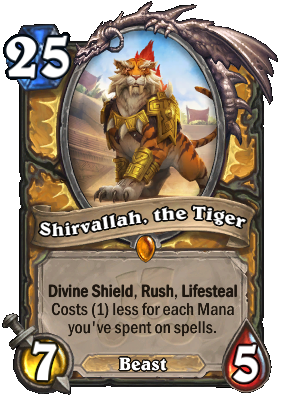

In [53]:
load_card(90145)   #Por ID 

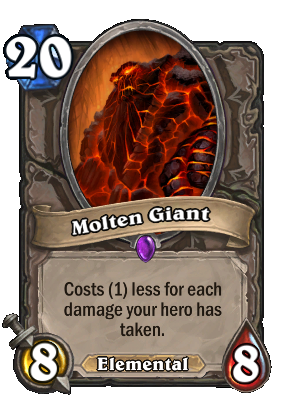

In [20]:
load_card(cards.index[7]) #Por indice 

Por otro lado, se puede observar que la columna `raw_attributes` es una especie de tupla, por lo que se tiene que manejar de otra manera. Análisando otros objetos se pudo observar que los datos vacíos están representados con una lista vacía, es decir, `{}`, por lo que hay que tener eso en consideración. A continuación revisaremos cuantos datos corresponden a este valor:

In [21]:
cards[cards.raw_attributes == "{}"]["name"].count()

844

Por lo tanto tenemos como mínimo 844 datos con esta columna con datos nulos.

Por último, revisaremos las columnas restantes, es decir, `type`, `class`, `rarity`, `set` y `race`. Para esto veremos su distribución de valores.

In [ ]:
cards.groupby("type").count()["name"]

type
ability     737
minion     1806
weapon       85
Name: name, dtype: int64

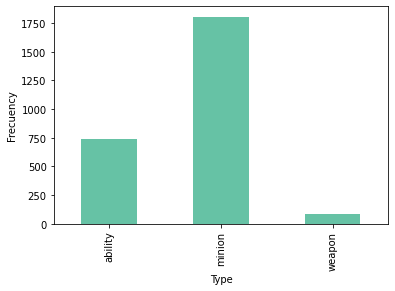

In [ ]:
cards.groupby("type").count()["name"].plot(xlabel="Type", ylabel="Frecuency", kind='bar', colormap='Set2')

Podemos observar que tenemos 3 valores para el atributo `type`. Estos corresponden a `ability`,  `weapon` y `minion`, siendo este último el con más repeticiones. 

In [ ]:
cards.groupby("class").count()["name"]

class
 druid      204
 hunter     185
 mage       188
 paladin    199
 priest     195
 rogue      179
 shaman     179
 warlock    186
 warrior    166
Name: name, dtype: int64

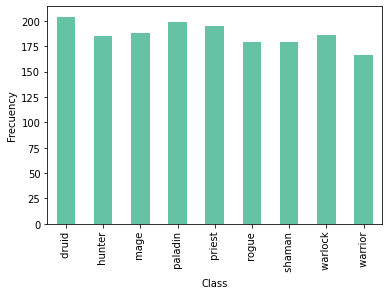

In [ ]:
cards.groupby("class").count()["name"].plot(xlabel="Class", ylabel="Frecuency", kind='bar', colormap='Set2')

De la misma manera, para el atributo `class` tenemos 9 valores. Estos corresponden a las 9 clases presentes en el juego. Como se mencionó anteriormente, estas clases influyen en el armado del mazo, ya que ciertas cartas solo pueden pertenecer a un mazo en el que el heroé sea de la misma clase.

In [ ]:
cards.groupby("rarity").count()["name"]

rarity
common       982
epic         424
free          85
legendary    417
rare         688
Name: name, dtype: int64

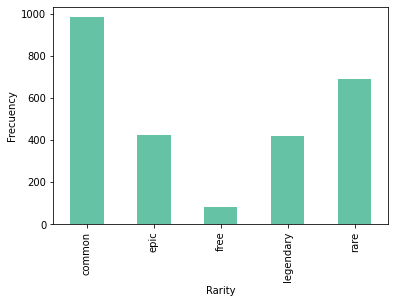

In [ ]:
cards.groupby("rarity").count()["name"].plot(xlabel="Rarity", ylabel="Frecuency", kind='bar', colormap='Set2')

Para el atributo `rarity` tenemos 6 valores distintos, siendo el valor `common` el con mayor frecuencia. Como se mencionó anteriormente, las cartas `legendary` solo pueden presentarse una vez por mazo.

In [ ]:
cards.groupby("set").count()["name"]

set
ashes of outland                 74
blackrock mountain               29
core (2022)                     220
curse of naxxramas               26
darkmoon faire                   70
descent of dragons               94
forged in the barrens            63
fractured in alterac valley      19
galakrond's awakening            19
goblins vs gnomes               115
hall of fame                    108
journey to un'goro              126
knights of the frozen throne    122
kobolds and catacombs           128
legacy                          170
mean streets of gadgetzan       129
missions                          9
one night in karazhan            38
rastakhan's rumble              127
removed from core                49
rise of shadows                 118
saviors of uldum                101
scholomance academy              68
tavern brawl                      6
the boomsday project            131
the grand tournament            121
the league of explorers          37
the witchwood           

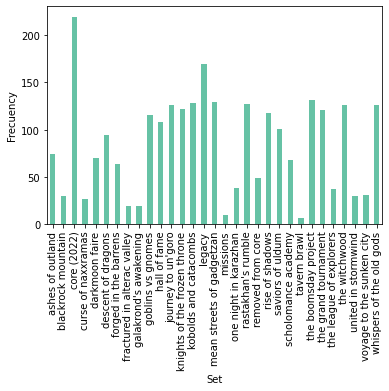

In [ ]:
cards.groupby("set").count()["name"].plot(xlabel="Set", ylabel="Frecuency", kind='bar', colormap='Set2')

En cuanto al atributo `set` tenemos aproximadamente 30 valores, los cuales corresponden al set al que corresponde cada carta. Esto se debe a que el juego lanza constantemente nuevos paquetes de cartas (aproximadamente cada 120 días). Como se mencionó anteriormente, para el modo de juego `Standard` solo se pueden usar cartas que pertenezcan a sets lanzados en los últimos 2 años.

In [ ]:
cards.groupby("race").count()["name"]

race
all             3
beast         211
demon          62
dragon         85
elemental     107
mechanical    123
murloc         51
naga            9
pirate         42
quillboar       7
totem          15
Name: name, dtype: int64

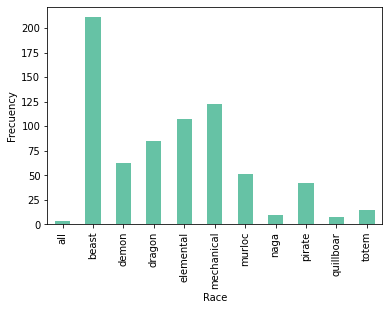

In [ ]:
cards.groupby("race").count()["name"].plot(xlabel="Race", ylabel="Frecuency", kind='bar', colormap='Set2')

Además tenemos el atributo `race`, el cual le permite tener ciertas interacciones especiales a las cartas durante las partidas. 

Por último, veamos la cantidad de datos nulos en las columnas que contienen datos vacíos.

In [ ]:
nul_attr_list = ['card_text', 'flavor_text', 'class', 'rarity', 'race']
for col in nul_attr_list:
    null_values = cards[col].isna().sum()
    print(f'Columna: {col} - Nulos: {null_values}')
    print('------------------------------------------------------')

Columna: card_text - Nulos: 47
------------------------------------------------------
Columna: flavor_text - Nulos: 52
------------------------------------------------------
Columna: class - Nulos: 947
------------------------------------------------------
Columna: rarity - Nulos: 32
------------------------------------------------------
Columna: race - Nulos: 1913
------------------------------------------------------


Notemos que en las columnas `class` y `race` hay una cantidad de nulos que no puede ser descartada, por lo que será necesario hacer un análisis de la influencia de estas columnas a la hora de hacer las recomendaciones.

## Análisis de los mazos (train.csv)

A continuación analizaremos los datos que usaremos para el entrenamiento. Estos cosisten en mazos ya armados por jugadores, los cuales contienen una lista de 30 cartas y ciertos atributos de este, que revisaremos a continuación.

In [6]:
df_train = pd.read_csv("train.csv", converters={"cards": json.loads})
df_train.set_index("deckid", inplace=True)

In [23]:
df_train.head()

update_date     hero  is_wild  \
deckid                                                               
b5407c84-8aa8-420d-9cd4-162eeee8762f  2013-05-23  paladin     True   
03376e41-6934-4ebd-9256-5a96c1760ac7  2013-05-23  paladin     True   
72301a26-1825-4ec4-88aa-132ac97da5e1  2013-05-23   shaman     True   
60273017-9a7a-4336-bc31-d5bcf662d3ef  2013-05-24   shaman     True   
dfc220aa-6253-4d2f-8707-47523e3ae88a  2013-05-24   shaman     True   

                                      is_standard  \
deckid                                              
b5407c84-8aa8-420d-9cd4-162eeee8762f        False   
03376e41-6934-4ebd-9256-5a96c1760ac7        False   
72301a26-1825-4ec4-88aa-132ac97da5e1        False   
60273017-9a7a-4336-bc31-d5bcf662d3ef        False   
dfc220aa-6253-4d2f-8707-47523e3ae88a        False   

                                                                                  cards  
deckid                                                                                   
b5407c84-8aa8-420d-9cd4-162eeee8762f  [21, 21, 142, 206, 206, 350, 350, 394, 422, 42...  
03376e41-6934-4ebd-9256-5a96c1760ac7  [53, 142, 206, 250, 318, 350, 355, 394, 439, 4...  
72301a26-1825-4ec4-88aa-132ac97da5e1  [67, 67, 77, 77, 84, 84, 216, 233, 233, 388, 4...  
60273017-9a7a-4336-bc31-d5bcf662d3ef  [54, 54, 140, 217, 289, 289, 510, 510, 526, 52...  
dfc220aa-6253-4d2f-8707-47523e3ae88a  [55, 55, 88, 88, 152, 152, 217, 275, 275, 289,...

In [24]:
df_train.shape

(606941, 5)

In [25]:
for col in df_train.columns:
    null_values = df_train[col].isna().sum()
    print(col)

update_date
hero
is_wild
is_standard
cards


Como podemos observar, tenemos los atributos:
* `update_date`: fecha en la que se actualizó ese mazo. 
* `hero`: corresonde a la clase del heroe elegido para ese mazo, el cual es elegido por el jugador. Hay 10 clases diferentes y corresponden a las mismas que se observaron en el dataset de las cartas(`cards.csv`) en el atributo `class`.
* `is_wild`: indica si el mazo pertenece al modo de juego `Wild`.
* `is_standard`: indica si el mazo pertenece al modo de juego `Standard`.
* `cards`: corresponde a las 30 cartas que cotiene este mazo.

Ahora veremos la distribución de los atributos `hero`, `is_wild` y `is_standard`

In [26]:
df_train.groupby("hero").count()['cards']

hero
druid      65066
hunter     58423
mage       81445
paladin    78818
priest     84103
rogue      66114
shaman     64825
warlock    43445
warrior    64702
Name: cards, dtype: int64

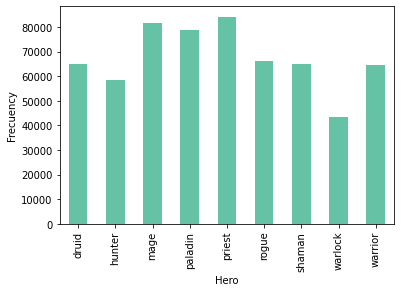

In [27]:
df_train.groupby("hero").count()['cards'].plot(xlabel="Hero", ylabel="Frecuency", kind='bar', colormap='Set2')

Podemos obsvervar que tenemos 9 valores. Como se mencionó anteriormente, estos valores estan vinculados con el atributo `class` de las cartas.

In [28]:
df_train.groupby("is_wild").count()['cards']

is_wild
False        24
True     606917
Name: cards, dtype: int64

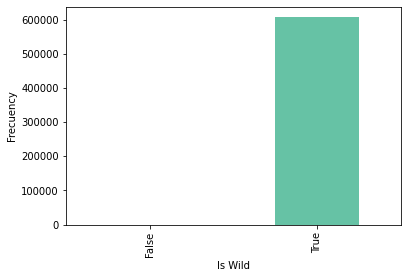

In [29]:
df_train.groupby("is_wild").count()['cards'].plot(xlabel="Is Wild", ylabel="Frecuency", kind='bar', colormap='Set2')

In [30]:
df_train.groupby("is_standard").count()['cards']

is_standard
False    606917
True         24
Name: cards, dtype: int64

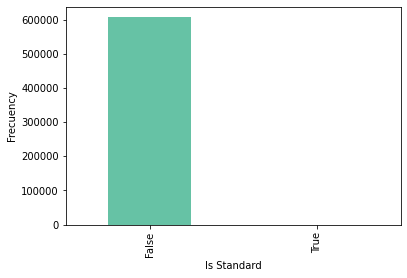

In [31]:
df_train.groupby("is_standard").count()['cards'].plot(xlabel="Is Standard", ylabel="Frecuency", kind='bar', colormap='Set2')

Notemos que un mazo solo puede ser `Wild` o `Standard`. Por otro lado, tenemos una ditribución muy dispareja de estos valores, ya que tenemos solo `24 mazos de tipo Standard`, mientras que del tipo `Wild tenemos los 606917 valores restantes`.

De la misma manera que se realizó con las cartas, usaremos un código extraído de https://www.kaggle.com/code/sosperec/visualize-hearthstone-prediction para ver la cartas que contiene un mazo.

In [54]:
def show_deck(deck, preds=[], rows=3):
    deck.sort(key=lambda x: (cards.loc[x]["cost"], cards.loc[x]["name"]))
    deck_cards = [load_card(c) for c in deck]
    pred_cards = [load_card(c) for c in preds]
    # enough cols for all cards, if there are preds, we skip a space
    cols = int((len(deck) + len(preds) + rows - (not len(preds)))/rows)
    fig, ax = plt.subplots(rows, cols, figsize=(cols*1.7, rows*2.5))
    ax = ax.ravel()
    for i, img in enumerate(deck_cards + pred_cards):
        if not len(deck) % cols == 0 and i >= len(deck):
            i += 1
        ax[i].imshow(img)
    for axes in ax:
        axes.axis("off")
    fig.tight_layout()

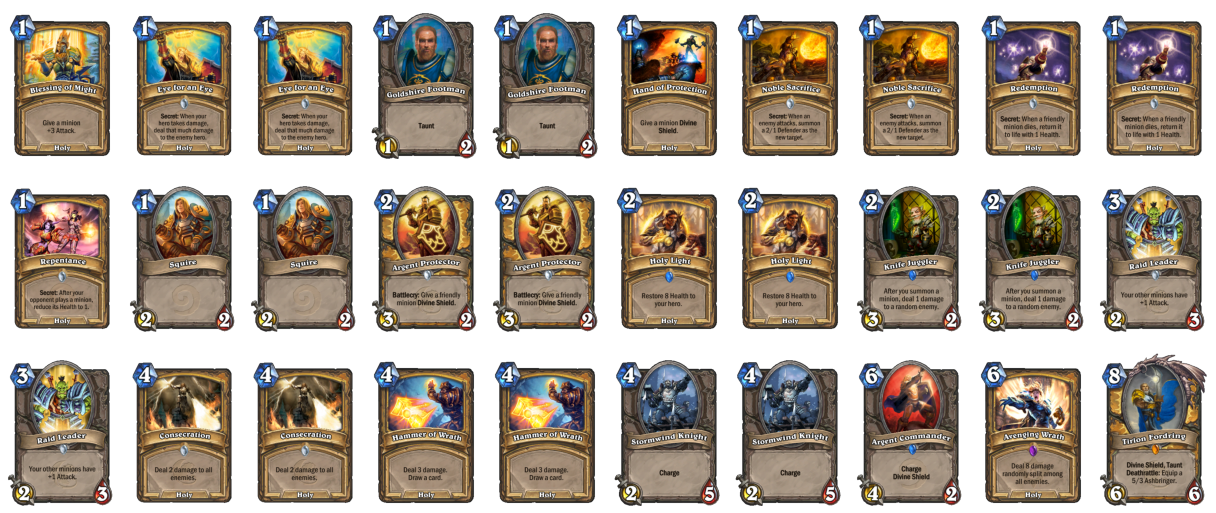

In [55]:
show_deck(df_train.iloc[0]['cards'])

### Analisis de cartas en mazos

In [ ]:
# Convertimos las cartas de cada mazo en filas (.explode), para luego ver su frecuencia
top_cards = df_train['cards'].explode().value_counts().to_frame('Frequency').sort_values('Frequency', ascending =False).reset_index()
top_cards.rename(columns={"index":"Card ID"}, inplace=True)

# Rarest cards 
rarest_cards = df_train['cards'].explode().value_counts().to_frame('Frequency').sort_values('Frequency', ascending =True).reset_index()
rarest_cards.rename(columns={"index":"Card ID"}, inplace=True)

Visualizamos las top 10 cartas más y menos comunes de todos los mazos

In [ ]:
n = 10
top_cards.head(n)

Card ID  Frequency
0  1024957     223627
1  1024953     134139
2     7749     131917
3      177     128196
4      431     123238
5      422     122848
6   475124     117844
7    12191     116072
8  1024939     113836
9   475022     111124

In [ ]:
rarest_cards.head(n)

Card ID  Frequency
0    35394          1
1      299          1
2      219          1
3      408          1
4    35391          1
5       58          1
6    35386          1
7       45          1
8    35385          1
9    52584          1

Visualicemos la distribución de las primeras 10 cartas más frecuentes

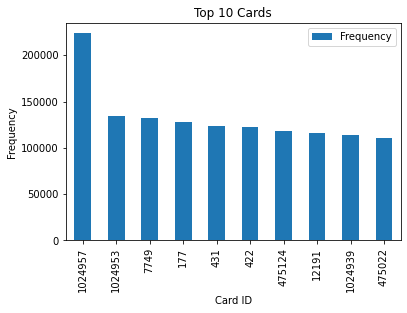

In [ ]:
top_cards.head(n).plot(x="Card ID", y="Frequency",kind="bar", ylabel = "Frequency", title=f"Top {n} Cards")

Visualizar cuales son las n cartas más frecuentes, y más raras (menos frecuentes)

In [ ]:
def display_top_cards(n):
  cards_id = []
  for i in range(0,n):
    card = top_cards.head(n)["Card ID"][i]
    cards_id.append(card)
  for card in cards_id:
    display(load_card(card))

def display_rarest_cards(n):
  cards_id = []
  for i in range(0,n):
    card = rarest_cards.head(n)["Card ID"][i]
    cards_id.append(card)
  for card in cards_id:
    display(load_card(card))

TOP 10 cartas (de más a menos , en terminos de su frecuencia en los mazos de train)

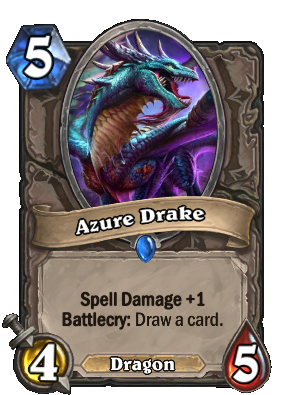

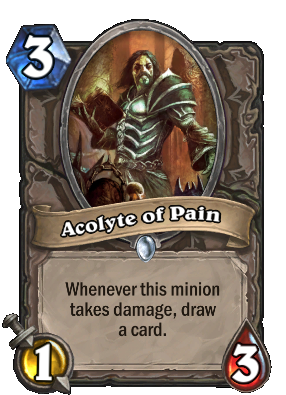

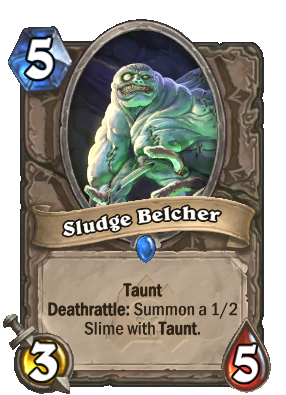

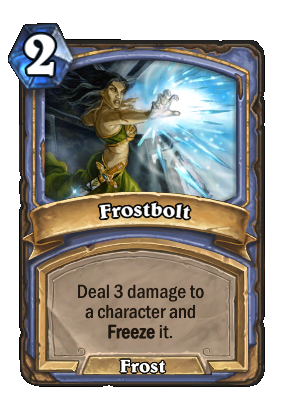

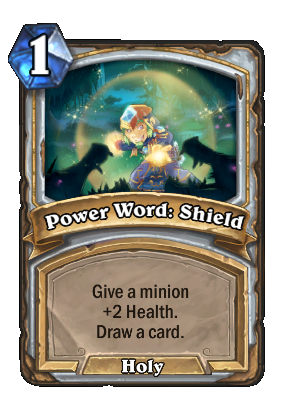

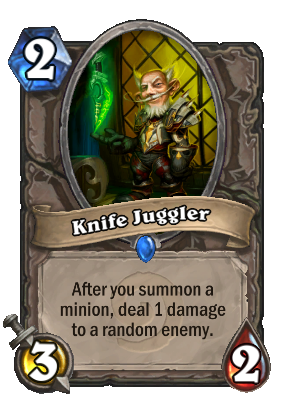

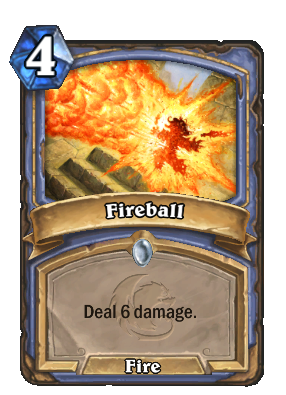

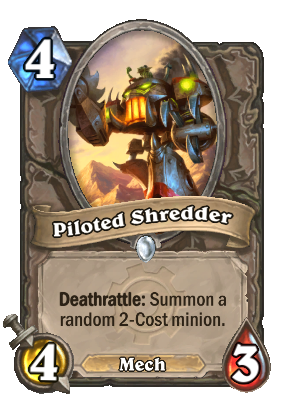

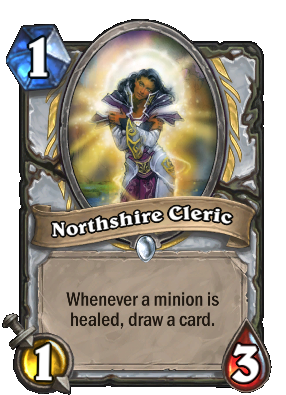

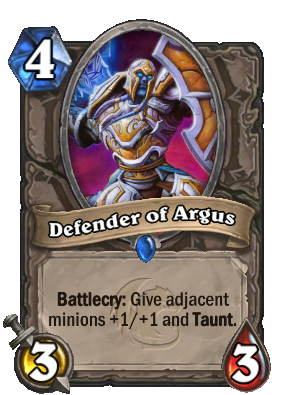

In [ ]:
display_top_cards(10) 

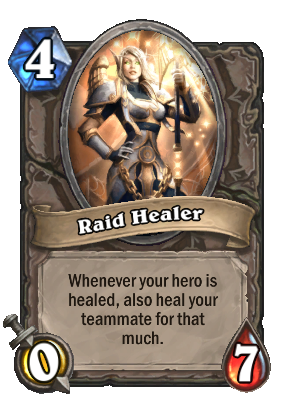

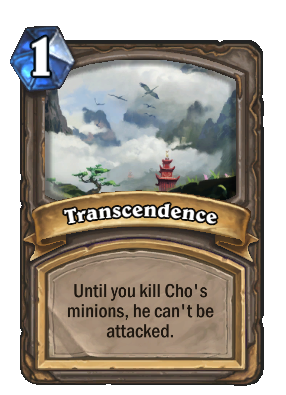

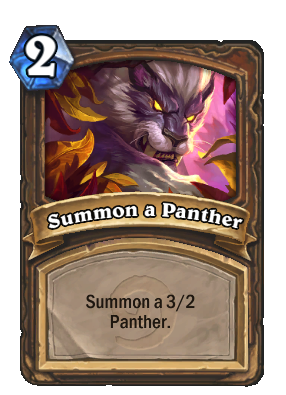

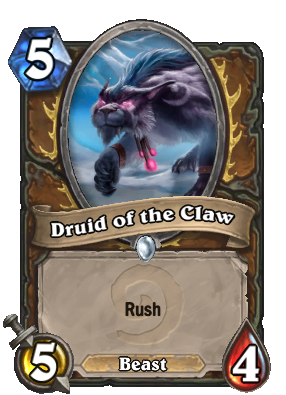

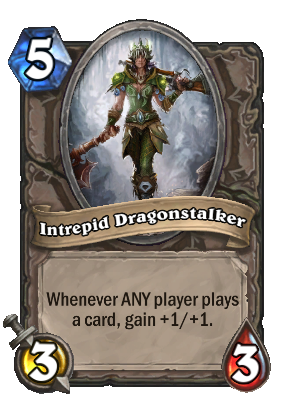

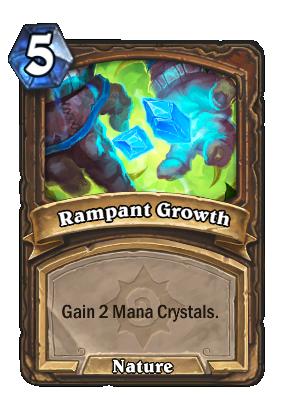

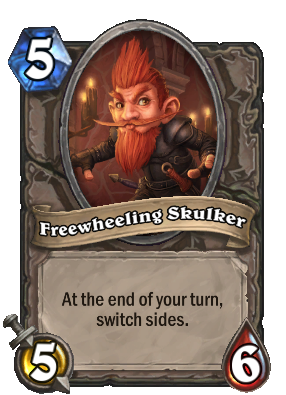

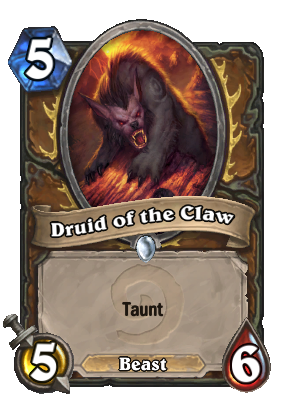

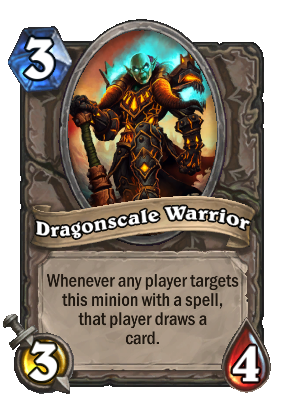

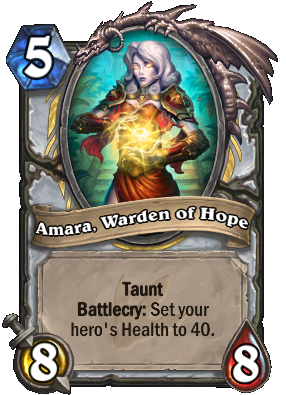

In [ ]:
display_rarest_cards(10)

Graficamos la distribución de la frecuencia de todas las cartas

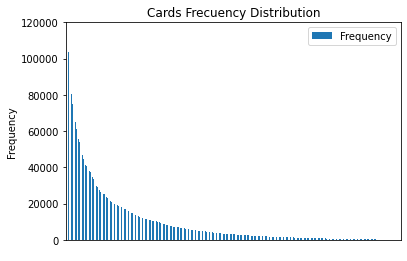

In [ ]:
plot = top_cards.plot(x="Card ID", y="Frequency",kind="bar", xlabel=" ", ylabel = "Frequency", title=f"Cards Frecuency Distribution")
# https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
plot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plot.set_ylim([0, 120000])
plot

No hemos incluido el id de cada carta en el gráfico, ya que la intención es mostrar la forma de la curva. Notemos que tenemos la típica curva de interacción con ítems, en la cual algunos ítems (en este caso cartas) se llevan la mayoría de las interacciones.  

## Análisis del set de test (test.csv)

Ahora realizamos el mismo analisis respecto de los datos del set de test

In [56]:
df_test = pd.read_csv("test.csv", converters={"cards": json.loads})
df_test.set_index("deckid", inplace=True)

In [57]:
df_test.head()

update_date     hero  is_wild  \
deckid                                                               
90509acf-14b3-46c2-baab-94226b4f1ae5  2018-08-29   priest     True   
edbc7193-15d8-4d63-813a-8b02896aebaf  2018-08-29  paladin     True   
3e1e5712-c7de-4e4b-83b0-639fbeedd98f  2018-08-29   hunter     True   
27037494-cbdc-4f25-a479-a6d266361f07  2018-08-29   priest     True   
6a307895-2441-4ebf-9653-6b54e2e0111b  2018-08-29     mage     True   

                                      is_standard  \
deckid                                              
90509acf-14b3-46c2-baab-94226b4f1ae5        False   
edbc7193-15d8-4d63-813a-8b02896aebaf        False   
3e1e5712-c7de-4e4b-83b0-639fbeedd98f        False   
27037494-cbdc-4f25-a479-a6d266361f07        False   
6a307895-2441-4ebf-9653-6b54e2e0111b        False   

                                                                       cards_incomplete  
deckid                                                                                   
90509acf-14b3-46c2-baab-94226b4f1ae5  [38, 38, 88, 88, 303, 315, 315, 401, 415, 415,...  
edbc7193-15d8-4d63-813a-8b02896aebaf  [75, 75, 463, 567, 567, 675, 61831, 61832, 618...  
3e1e5712-c7de-4e4b-83b0-639fbeedd98f  [386, 386, 12176, 12188, 12188, 12190, 12254, ...  
27037494-cbdc-4f25-a479-a6d266361f07  [315, 431, 431, 52588, 55463, 55463, 55540, 55...  
6a307895-2441-4ebf-9653-6b54e2e0111b  [4, 4, 49, 49, 220, 55552, 55552, 55553, 55553...

In [58]:
df_test.shape

(2221, 5)

In [59]:
for col in df_test.columns:
    null_values = df_test[col].isna().sum()
    print(col)

update_date
hero
is_wild
is_standard
cards_incomplete


Única diferencia, lógicamente, es que las cartas de test están incompletas a falta de la carta que se debe predecir.  Esto se describe con la variable `cards_incomplete`.

In [60]:
df_test.groupby("hero").count()['cards_incomplete']

hero
druid      198
hunter     140
mage       271
paladin    348
priest     299
rogue      412
shaman     184
warlock    265
warrior    104
Name: cards_incomplete, dtype: int64

Comparamos la distribución de `hero` en ambos sets:

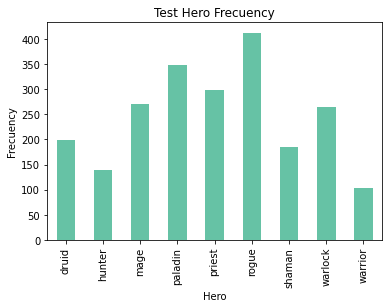

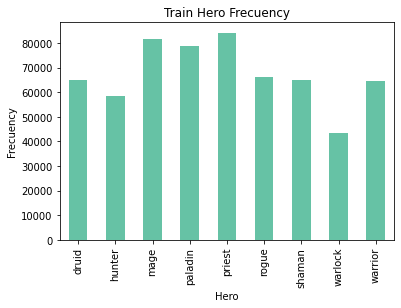

In [ ]:
plt.show(df_test.groupby("hero").count()['cards_incomplete'].plot(title = "Test Hero Frecuency",xlabel="Hero", ylabel="Frecuency", kind='bar', colormap='Set2'))
plt.show(df_train.groupby("hero").count()['cards'].plot(title = "Train Hero Frecuency",xlabel="Hero", ylabel="Frecuency", kind='bar', colormap='Set2'))

In [ ]:
df_test.groupby("is_wild").count()['cards_incomplete']

is_wild
True    2221
Name: cards_incomplete, dtype: int64

Otra diferencia observable, es que en el set de test, todos los mazos son el tipo `Standard`. De todas maneras, en el set de train la distribución era igualmente muy dispareja (24 de 606.917).

#Procesamiento de los datasets

## Tratamiento de Nulos "Cards"

Veamos las columnas con más nulos en el DF

In [ ]:
cards.isnull().sum().sort_values(ascending=False)

race                    1913
class                    947
flavor_text               52
card_text                 47
rarity                    32
id                         0
is_windfury_card           0
is_overload_card           0
is_lifesteal_card          0
is_freeze_card             0
is_discover_card           0
is_secret_card             0
is_echo_card               0
is_stealth_card            0
cost                       0
attack                     0
is_charge_card             0
is_taunt_card              0
is_inspire_card            0
is_combo_card              0
name                       0
is_deathrattle_card        0
is_rush_card               0
is_divineshield_card       0
is_battlecry_card          0
raw_attributes             0
set                        0
type                       0
img                        0
health                     0
dtype: int64

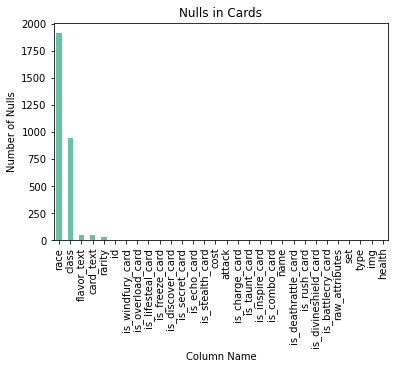

In [ ]:
cards.isnull().sum().sort_values(ascending=False).plot(xlabel="Column Name", ylabel="Number of Nulls", kind='bar', colormap='Set2', title = "Nulls in Cards")

Como puede observarse, las columnas con mayor cantidad de nulos son "*race*", "*class*", "*flavor_text*, "*card_text*" y "*rarity*". "Race"sobrepasa en gran medida a las demás con 1913 nulos. 

Race es un atributo que se le asigna a las cartas del tipo "*minion*", también conocido como "*tribu*" o "*tribe*", en inglés. No todos los "minions" tienen una "raza" asignada. De hecho, el [sitio del fandom de Hearthstone ](https://hearthstone.fandom.com/wiki/Minion) detalla que la mayoria de los minions no tienen una raza definida, por lo que no es exatraño que hay tanto nulos.

Dado que son muchas las cartas sin "race", asignaremos un valor "no_race" para poder trabajar con estas.

In [ ]:
cards["race"].fillna("no_race", inplace = True)
cards["race"].value_counts()

no_race       1913
beast          211
mechanical     123
elemental      107
dragon          85
demon           62
murloc          51
pirate          42
totem           15
naga             9
quillboar        7
all              3
Name: race, dtype: int64

Luego con "*class*" sucede algo similar. La clase de una carta es aplicable para las cartas del tipo "*hero*", aquellas que solo pueden estar una vez en el mazo. También las "weapons", que solo son utilizables por los heroes, tienen asignadas clases especificas en algunos casos, pero no necesariamente para todas. Por último, las "abilities" se pueden asignar también a minions y weapons (además de los heros), pero tienen una clase asignada cuando están vinculadas con un héroe. En estos casos, la clase del héroe define la clase de la habilidad. 

In [ ]:
# Asignando clase "no class", a aquellas cartas sin una clase asociada.
cards["class"].fillna("no_class", inplace = True)
cards["class"].value_counts() 

no_class    947
 druid      204
 paladin    199
 priest     195
 mage       188
 warlock    186
 hunter     185
 shaman     179
 rogue      179
 warrior    166
Name: class, dtype: int64

Para los textos del tipo "null", reemplazaremos este valor por un string vacio = "". 

In [ ]:
# Cartas sin flavor text = ""
cards["flavor_text"].fillna("", inplace = True)
cards["flavor_text"].value_counts() 

                                                                                      52
"Is this about justice or just us?"                                                    2
It's like déjà vu, times two.                                                          2
Have you seen the size of the shields in this game?? This is no easy job.              1
They’re just baby teeth. Lots and lots of baby teeth.                                  1
                                                                                      ..
The yetis of Chillwind Point are a source of both inspiration and savage beatings.     1
"Hey.... Is that Mire for sale?"\n"No. I'm keeping it."                                1
Hee hee! Look at his cute little feet.                                                 1
Hook-tails are nice and all but she keeps getting stuck on things.                     1
You could have just pointed.                                                           1
Name: flavor_text, Le

In [ ]:
# Cartas sin card_text = ""
cards["card_text"].fillna("", inplace = True)
cards["card_text"].value_counts() 

                                                                 47
Taunt                                                            33
Spell Damage +1                                                   9
Stealth                                                           8
Charge                                                            8
                                                                 ..
Battlecry: Gain +1 Attack for each other cardin your hand.        1
RushBattlecry: Gain +3 Attack this turn.                          1
Whenever you play an Echo card, gain +1/+1.                       1
Deathrattle: Draw 2 Murlocsfrom your deck.                        1
After your Hero attacks a minion, your minions attack it too.     1
Name: card_text, Length: 2407, dtype: int64

Dado que rarity es un valor ordinal, y no categorico (es decir las cartas más raras son más valiosas, y menos comunes, que las más "comunes", le asignaremos un valor de 0 a aquellas sin rarity (null), para más adelante ordenar del 1 al5 según su rarity. 

In [ ]:
cards["rarity"] = cards["rarity"].fillna(0)
cards.loc[cards['rarity'] == 0]

id                    name  \
452   52584   Amara, Warden of Hope   
517     354               Devilsaur   
547   35386    Freewheeling Skulker   
558   35391  Intrepid Dragonstalker   
876   35392               Main Tank   
909   35394             Raid Healer   
1031  63171             Blood Beast   
1092  35385     Dragonscale Warrior   
1224    541            Pip Quickwit   
1580    451             Spirit Wolf   
1659    240         Emboldener 3000   
1669    318                Defender   
1721    405             Poultryizer   
1735    439              Repair Bot   
1752  63177         Skeletal Knight   
1756     21                  Squire   
1764     63       Violet Apprentice   
1791    527                   Whelp   
1799    552                 Chicken   
1802    582       Shadow of Nothing   
1820  27259        Lantern of Power   
1826    358         Demigod's Favor   
1843    159        Shan'do's Lesson   
1933    485                  Enrich   
1943     58          Rampant Growth   
2250    204      Leader of the Pack   
2290  35388        Shadow or Light?   
2319    219        Summon a Panther   
2362    231                 Bananas   
2538    141                The Coin   
2550     53              Ashbringer   
2611    403              Battle Axe   

                                                    img  \
452   https://cards.hearthpwn.com/enUS/UNG_940t8.png...   
517   https://cards.hearthpwn.com/enUS/EX1_tk29.png?...   
547   https://cards.hearthpwn.com/enUS/TB_Coopv3_101...   
558   https://cards.hearthpwn.com/enUS/TB_Coopv3_103...   
876   https://cards.hearthpwn.com/enUS/TB_Coopv3_104...   
909   https://cards.hearthpwn.com/enUS/TB_Coopv3_105...   
1031  https://cards.hearthpwn.com/enUS/ICCA09_001t1....   
1092  https://cards.hearthpwn.com/enUS/TB_Coopv3_100...   
1224  https://cards.hearthpwn.com/enUS/EX1_finkle.pn...   
1580  https://cards.hearthpwn.com/enUS/EX1_tk11.png?...   
1659  https://cards.hearthpwn.com/enUS/Mekka3.png?14...   
1669  https://cards.hearthpwn.com/enUS/EX1_130a.png?...   
1721  https://cards.hearthpwn.com/enUS/Mekka4.png?14...   
1735  https://cards.hearthpwn.com/enUS/Mekka2.png?14...   
1752  https://cards.hearthpwn.com/enUS/ICCA11_001.pn...   
1756  https://cards.hearthpwn.com/enUS/CS2_152.png?1...   
1764  https://cards.hearthpwn.com/enUS/NEW1_026t.png...   
1791  https://cards.hearthpwn.com/enUS/ds1_whelptoke...   
1799  https://cards.hearthpwn.com/enUS/Mekka4t.png?1...   
1802  https://cards.hearthpwn.com/enUS/EX1_345t.png?...   
1820  https://cards.hearthpwn.com/enUS/LOEA16_3.png?...   
1826  https://cards.hearthpwn.com/enUS/EX1_573a.png?...   
1843  https://cards.hearthpwn.com/enUS/EX1_573b.png?...   
1933  https://cards.hearthpwn.com/enUS/EX1_164b.png?...   
1943  https://cards.hearthpwn.com/enUS/EX1_164a.png?...   
2250  https://cards.hearthpwn.com/enUS/EX1_160b.png?...   
2290  https://cards.hearthpwn.com/enUS/TB_Coopv3_102...   
2319  https://cards.hearthpwn.com/enUS/EX1_160a.png?...   
2362  https://cards.hearthpwn.com/enUS/EX1_014t.png?...   
2538  https://cards.hearthpwn.com/enUS/GAME_005.png?...   
2550  https://cards.hearthpwn.com/enUS/EX1_383t.png?...   
2611  https://cards.hearthpwn.com/enUS/EX1_398t.png?...   

                                              card_text  \
452        TauntBattlecry: Set yourhero's Health to 40.   
517                                                       
547              At the end of your turn, switch sides.   
558       Whenever ANY player plays a card, gain +1/+1.   
876   Battlecry: Give all other minions +2/+2, excep...   
909   Whenever your hero is healed, also heal your t...   
1031  At the start of your turn, restore 3 Health to...   
1092  Whenever any player targets this minion with a...   
1224                                                      
1580                                              Taunt   
1659  At the end of your turn, give a random minion ...   
1669                                                      
1721  

Con eso hemos procesado todos los nulos de nuestro dataset. 

In [ ]:
cards.isnull().sum().sort_values(ascending=False)

id                      0
name                    0
attack                  0
cost                    0
is_secret_card          0
is_echo_card            0
is_windfury_card        0
is_discover_card        0
is_freeze_card          0
is_lifesteal_card       0
is_overload_card        0
is_charge_card          0
is_stealth_card         0
is_inspire_card         0
is_combo_card           0
is_taunt_card           0
is_deathrattle_card     0
is_rush_card            0
is_divineshield_card    0
is_battlecry_card       0
raw_attributes          0
race                    0
set                     0
rarity                  0
class                   0
type                    0
flavor_text             0
card_text               0
img                     0
health                  0
dtype: int64

## Conversión de columnas 


Class codificado tipo "one hot encoging", con get_dummies

In [ ]:
# DF previo al procesamiento de las columnas
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    2628 non-null   int64 
 1   name                  2628 non-null   object
 2   img                   2628 non-null   object
 3   card_text             2628 non-null   object
 4   flavor_text           2628 non-null   object
 5   type                  2628 non-null   object
 6   class                 2628 non-null   object
 7   rarity                2628 non-null   object
 8   set                   2628 non-null   object
 9   race                  2628 non-null   object
 10  raw_attributes        2628 non-null   object
 11  is_battlecry_card     2628 non-null   bool  
 12  is_divineshield_card  2628 non-null   bool  
 13  is_rush_card          2628 non-null   bool  
 14  is_deathrattle_card   2628 non-null   bool  
 15  is_taunt_card         2628 non-null   

Hacemos la conversión de las columnas, y eliminamos la columna "class" procesada.

In [ ]:
cards = pd.get_dummies(cards, columns=['class'], prefix = "is")

In [ ]:
#DF posterior al procesamiento de columna class
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    2628 non-null   int64 
 1   name                  2628 non-null   object
 2   img                   2628 non-null   object
 3   card_text             2628 non-null   object
 4   flavor_text           2628 non-null   object
 5   type                  2628 non-null   object
 6   rarity                2628 non-null   object
 7   set                   2628 non-null   object
 8   race                  2628 non-null   object
 9   raw_attributes        2628 non-null   object
 10  is_battlecry_card     2628 non-null   bool  
 11  is_divineshield_card  2628 non-null   bool  
 12  is_rush_card          2628 non-null   bool  
 13  is_deathrattle_card   2628 non-null   bool  
 14  is_taunt_card         2628 non-null   bool  
 15  is_combo_card         2628 non-null   

Ahora realizamos lo mismo, con Type.

In [ ]:
cards = pd.get_dummies(cards, columns=['type'], prefix = "is")
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    2628 non-null   int64 
 1   name                  2628 non-null   object
 2   img                   2628 non-null   object
 3   card_text             2628 non-null   object
 4   flavor_text           2628 non-null   object
 5   rarity                2628 non-null   object
 6   set                   2628 non-null   object
 7   race                  2628 non-null   object
 8   raw_attributes        2628 non-null   object
 9   is_battlecry_card     2628 non-null   bool  
 10  is_divineshield_card  2628 non-null   bool  
 11  is_rush_card          2628 non-null   bool  
 12  is_deathrattle_card   2628 non-null   bool  
 13  is_taunt_card         2628 non-null   bool  
 14  is_combo_card         2628 non-null   bool  
 15  is_inspire_card       2628 non-null   

Misma conversión para Set, con "*get_dummies*"

In [ ]:
cards = pd.get_dummies(cards, columns=['set'], prefix = "is")
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 71 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               2628 non-null   int64 
 1   name                             2628 non-null   object
 2   img                              2628 non-null   object
 3   card_text                        2628 non-null   object
 4   flavor_text                      2628 non-null   object
 5   rarity                           2628 non-null   object
 6   race                             2628 non-null   object
 7   raw_attributes                   2628 non-null   object
 8   is_battlecry_card                2628 non-null   bool  
 9   is_divineshield_card             2628 non-null   bool  
 10  is_rush_card                     2628 non-null   bool  
 11  is_deathrattle_card              2628 non-null   bool  
 12  is_taunt_card                    2

Y finalmente race, get_dummies

In [ ]:
cards = pd.get_dummies(cards, columns=['race'], prefix = "is")
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               2628 non-null   int64 
 1   name                             2628 non-null   object
 2   img                              2628 non-null   object
 3   card_text                        2628 non-null   object
 4   flavor_text                      2628 non-null   object
 5   rarity                           2628 non-null   object
 6   raw_attributes                   2628 non-null   object
 7   is_battlecry_card                2628 non-null   bool  
 8   is_divineshield_card             2628 non-null   bool  
 9   is_rush_card                     2628 non-null   bool  
 10  is_deathrattle_card              2628 non-null   bool  
 11  is_taunt_card                    2628 non-null   bool  
 12  is_combo_card                    2

Rarity to ordinal. Dado que, tal como señala la [wiki de Hearthstone](https://hearthstone.fandom.com/wiki/Rarity), 
"*Rarity is a rough measure of the quality and scarcity of a card. Cards of higher rarity are typically harder to find and more expensive to craft.*", por lo que asignaremos valores más altos a las clases más raras. Véase la siguiente tabla:

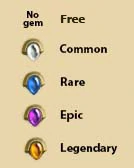




In [ ]:
cards['rarity'].replace(['free', 'common', 'rare','epic','legendary'],
                        [1,2,3,4,5], inplace=True)

Por último, la columna **raw_attributes** se codificó de manera similar, pero en vez de obtener 0 y 1 del tipo "unit8", son columnas con datos **booleanos**. Para que todos los valores sean del mismo tipo, también convertiremos las columnas **cost**, **attack**, **health** (y la ordinal recien transformada, **rarity**) de **int64**, igualmente a "***unit8***". 

In [ ]:
cards = cards.astype({"is_battlecry_card": np.uint8,
                      "is_divineshield_card": np.uint8,
                      "is_rush_card": np.uint8,
                      "is_deathrattle_card": np.uint8,
                      "is_taunt_card": np.uint8,
                      "is_combo_card": np.uint8,
                      "is_inspire_card": np.uint8,
                      "is_stealth_card": np.uint8,
                      "is_charge_card": np.uint8,
                      "is_overload_card": np.uint8,
                      "is_lifesteal_card": np.uint8,
                      "is_freeze_card": np.uint8,
                      "is_discover_card": np.uint8,
                      "is_windfury_card": np.uint8,
                      "is_echo_card": np.uint8,
                      "is_secret_card": np.uint8,                
                      "cost": np.uint8,
                      "attack": np.uint8,
                      "health": np.uint8,
                      "rarity": np.uint8})

In [ ]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               2628 non-null   int64 
 1   name                             2628 non-null   object
 2   img                              2628 non-null   object
 3   card_text                        2628 non-null   object
 4   flavor_text                      2628 non-null   object
 5   rarity                           2628 non-null   uint8 
 6   raw_attributes                   2628 non-null   object
 7   is_battlecry_card                2628 non-null   uint8 
 8   is_divineshield_card             2628 non-null   uint8 
 9   is_rush_card                     2628 non-null   uint8 
 10  is_deathrattle_card              2628 non-null   uint8 
 11  is_taunt_card                    2628 non-null   uint8 
 12  is_combo_card                    2

Finalmente, eliminaremos la columna raw_attributes, dado que ya tenemos su codificación al estilo "one hot encoding". 

In [ ]:
cards.drop(columns='raw_attributes', inplace=True)

Veamos el DF final de cards

In [ ]:
# Configuremos el DF para ver todas sus columnas, con sus respectivos valores
pd.set_option('display.max_columns', None)
cards.drop(columns=["name","img","card_text","flavor_text"],inplace=True)
cards.to_csv("one_hot.csv")

Unnamed: 0      id  rarity  is_battlecry_card  is_divineshield_card  \
0              0   90145       5                  0                     1   
1              1   42049       4                  0                     0   
2              2  475011       4                  0                     0   
3              3     264       4                  0                     0   
4              4   31110       5                  1                     0   
...          ...     ...     ...                ...                   ...   
2623        2623   55496       3                  0                     0   
2624        2624  329906       5                  0                     0   
2625        2625   42042       2                  0                     0   
2626        2626   90271       2                  0                     0   
2627        2627  329946       4                  0                     0   

      is_rush_card  is_deathrattle_card  is_taunt_card  is_combo_card  \
0                1                    0              0              0   
1                0                    0              0              0   
2                0                    0              0              0   
3                0                    0              0              0   
4                0                    0              0              0   
...            ...                  ...            ...            ...   
2623             0                    0              0              0   
2624             0                    0              0              0   
2625             0                    0              0              0   
2626             1                    1              0              0   
2627             0                    0              0              0   

      is_inspire_card  is_stealth_card  is_charge_card  is_overload_card  \
0                   0                0               0                 0   
1                   0                0               0                 0   
2                   0                0               0                 0   
3                   0                0               0                 0   
4                   0                0               0                 0   
...               ...              ...             ...               ...   
2623                0                0               0                 0   
2624                0                0               0                 0   
2625                0                0               0                 0   
2626                0                0               0                 0   
2627                0                0               0                 0   

      is_lifesteal_card  is_freeze_card  is_discover_card  is_windfury_card  \
0                     1               0                 0                 0   
1                     0               0                 0                 0   
2                     0               0                 0                 0   
3                     0               0                 0                 0   
4                     0               0                 0                 0   
...                 ...             ...               ...               ...   
2623                  0               0                 0                 0   
2624                  0               0                 0                 0   
2625                  0               0                 0                 0   
2626                  0               0                 0                 0   
2627                  0               0                 0                 0   

      is_echo_card  is_secret_card  cost  attack  health  is_ druid  \
0                0               0    25       7       5          0   
1                0               0    12       8       8          0   
2                0               0    12       8       8          0   
3                0               0    12       8       8  

In [ ]:
cards

id  rarity  is_battlecry_card  is_divineshield_card  is_rush_card  \
0      90145       5                  0                     1             1   
1      42049       4                  0                     0             0   
2     475011       4                  0                     0             0   
3        264       4                  0                     0             0   
4      31110       5                  1                     0             0   
...      ...     ...                ...                   ...           ...   
2623   55496       3                  0                     0             0   
2624  329906       5                  0                     0             0   
2625   42042       2                  0                     0             0   
2626   90271       2                  0                     0             1   
2627  329946       4                  0                     0             0   

      is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                       0              0              0                0   
1                       0              0              0                0   
2                       0              0              0                0   
3                       0              0              0                0   
4                       0              0              0                0   
...                   ...            ...            ...              ...   
2623                    0              0              0                0   
2624                    0              0              0                0   
2625                    0              0              0                0   
2626                    1              0              0                0   
2627                    0              0              0                0   

      is_stealth_card  is_charge_card  is_overload_card  is_lifesteal_card  \
0                   0               0                 0                  1   
1                   0               0                 0                  0   
2                   0               0                 0                  0   
3                   0               0                 0                  0   
4                   0               0                 0                  0   
...               ...             ...               ...                ...   
2623                0               0                 0                  0   
2624                0               0                 0                  0   
2625                0               0                 0                  0   
2626                0               0                 0                  0   
2627                0               0                 0                  0   

      is_freeze_card  is_discover_card  is_windfury_card  is_echo_card  \
0                  0                 0                 0             0   
1                  0                 0                 0             0   
2                  0                 0                 0             0   
3                  0                 0                 0             0   
4                  0                 0                 0             0   
...              ...               ...               ...           ...   
2623               0                 0                 0             0   
2624               0                 0                 0             0   
2625               0                 0                 0             0   
2626               0                 0                 0             0   
2627               0                 0                 0             0   

      is_secret_card  cost  attack  health  is_ druid  is_ hunter  is_ mage  \
0                  0    25       7       5          0           0         0   
1                  0    12       8       8          0           0         0   
2                  0    12       8       8          0           0         0   
3     

##Vectorizar imagenes


Se usó el módulo `Image` de la libreria `PIL` para transformar las imagenes en vectores.

In [ ]:
import matplotlib.pyplot  as plt
import cv2
# import wget
import requests
import shutil
from PIL import Image
import io
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# !mkdir cards_images #directorio para guardar imagenes 

Como se mencionó anteriormente, las imagenes vienen como un url, por lo que para obtenerlas hay que hacer el request a la página.

In [ ]:
#request
cards_img = []    # Cartas como imagenes  
# cards_img_np = [] # Cartas como array (Width, Height, Channels)
for index, row in tqdm(cards.iterrows()):
  card_id = row["id"]
  img_url = row["img"]
  filename = card_id
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  response = requests.get(img_url, stream = True, headers=headers)
  image = Image.open(io.BytesIO(response.content)).convert("RGB") # 3 canales para el embedding
  # image.save(f"/content/cards_images/card_{card_id}.jpg")  # Guardar imagenes OPCIONAL (jpeg, jpg)
  # image_np = np.asarray(image) #image as numpy arrays
  # cards_img_np.append(image_np) 
  cards_img.append(image)

2628it [41:40,  1.05it/s]


In [ ]:
import shutil
shutil.make_archive("cartas", 'zip', "/content/cards_images")

'/content/cartas.zip'

Para verficiar que haya funcionado se muestra la primera y última imagen según el DF original por ID. 

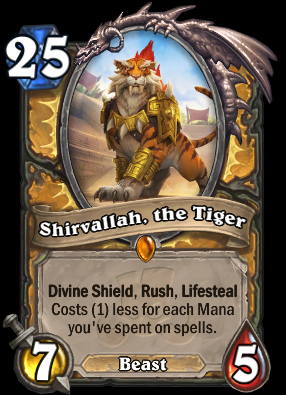

In [ ]:
#Primera carta ID 90145: "Shirvallah, the Tiger"
cards_img[0]

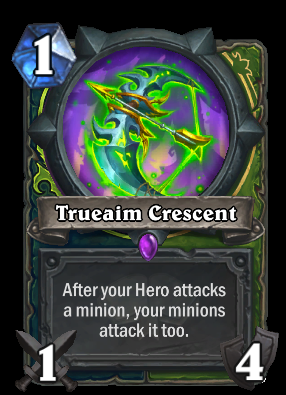

In [ ]:
#Última carta ID 329946: "Trueaim Crescent"
cards_img[-1]

##Embeddings de imagenes con Img2Vec

Importamos la libreria[ Img2Vec](https://pypi.org/project/img2vec-pytorch/), para generar embeddings en base a las imagenes obtenidas.

In [ ]:
!pip install img2vec_pytorch
from img2vec_pytorch import Img2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Definimos como modelo "Resnet-18", para trabajar con vectores de dimensionalidad 512.

In [ ]:
img2vec = Img2Vec(cuda=True, model="resnet-18")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Podemos pasarle la lista de vectores a img2vec. Definimos tensor= False para obtener valores del tipo numpy array, que nos permitan luego crear un DF de pandas en base a estos.

In [ ]:
vectors = []
for img in tqdm(cards_img):
  vector = img2vec.get_vec(img, tensor=False)
  vectors.append(vector)

100%|██████████| 2628/2628 [00:21<00:00, 122.42it/s]


Dimensiones de vector

In [ ]:
len(vectors[0])

512

Ahora se aplica la reducción de dimensionalidad al vector. Para este caso se reducirá a 100 dimensiones.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
def cards_reduction(dimensions, df, random_state=19637713):
  pca = PCA(n_components=dimensions, random_state=random_state, svd_solver='randomized')
  pca_df = pca.fit_transform(df)
  df_reducted = pd.DataFrame(pca_df)
  return df_reducted

In [ ]:
n_commponents = 100
cards_img_reducted = cards_reduction(n_commponents, vectors)
cards_img_reducted.to_csv(f"new_img_vecs_{n_commponents}_dimensions.csv", index=False)

Cada dimensión del vector a una columna 

In [ ]:
img_vec_cols = []
for i in range(0,100):
  name= f"img_vec{i}"
  img_vec_cols.append(name)

In [ ]:
vectors_df = pd.DataFrame(vectors)
vectors_df.columns = img_vec_cols

In [ ]:
vectors_df.to_csv("img_vectors.csv", index=False)

In [ ]:
vectors_df

img_vec0  img_vec1  img_vec2  img_vec3  img_vec4  img_vec5  img_vec6  \
0    -4.188042 -2.747162  0.460765 -3.583351  3.101084  0.969457 -0.120662   
1    -3.922827  2.731956 -0.442387  2.819026  0.374562  0.256614 -0.551568   
2    -4.790049  2.893840  0.314601  0.250362  0.068953  1.308857 -0.097858   
3    -3.602570 -3.541457 -0.367687 -0.082271 -1.739874  0.821640 -0.582504   
4    -2.589284 -3.204940  0.965583  0.077474  6.034249  0.724805  1.022371   
...        ...       ...       ...       ...       ...       ...       ...   
2623 -3.172393  5.839902  1.907580  3.853186  5.057810  5.047190  3.397042   
2624  0.179746  2.153972 -3.148754  6.260379  4.927413  4.040192  5.360909   
2625 -1.422967  1.128142 -0.371194  6.706503  6.125246  1.229490  2.176086   
2626 -2.044202  1.438785  4.982090  1.234130  5.655876  3.375825  6.303476   
2627  1.457935  2.115369 -4.042371  1.879620  4.767901  2.363479  4.005963   

      img_vec7  img_vec8  img_vec9  img_vec10  img_vec11  img_vec12  \
0    -1.340204  4.185872 -2.152037  -0.444892   0.174659  -0.873641   
1     0.661661 -2.252150 -0.999336  -0.903699  -0.073409  -1.107381   
2    -0.670322 -0.482004  1.318112  -0.183690  -2.159683  -3.316988   
3     1.109442 -0.529625  1.212269   1.116392  -0.225516  -1.084470   
4     1.641982 -0.661720 -1.375344   0.108270  -1.045623   0.916465   
...        ...       ...       ...        ...        ...        ...   
2623 -1.866441  1.555417  2.296754  -0.542368  -0.256684   0.152603   
2624 -2.500875 -0.985573  2.026202  -2.930778  -2.316736   0.325771   
2625 -1.742308 -0.089497  1.654593  -1.257335   3.251696  -0.244008   
2626 -2.162262  1.966350  1.346878   0.256614   0.351011  -0.911643   
2627  1.320988 -0.672404  2.589242   0.657202   2.108278  -3.421260   

      img_vec13  img_vec14  img_vec15  img_vec16  img_vec17  img_vec18  \
0     -0.068068   1.746515  -0.820786   0.518977  -0.323470   0.242678   
1      0.173115   1.141766  -1.302610  -1.115401   1.036954  -2.163915   
2     -2.278826   1.187948  -0.662661   0.039499  -0.458669  -2.635150   
3      1.692550   0.923028  -1.391485  -1.002822   0.855966   1.397895   
4      1.878403  -1.355248  -0.857592  -0.130767  -0.215716  -1.531614   
...         ...        ...        ...        ...        ...        ...   
2623   1.246218   0.167397   1.685780   0.305774  -0.403135   0.864708   
2624  -1.613508   2.709765  -1.676277  -1.668356   0.913955   0.445165   
2625   1.934648   0.460929   0.621565  -0.391639   0.018171   1.426209   
2626   1.517543   0.679814   0.893027  -0.066668   0.184270   0.486085   
2627   1.878792  -0.152121   1.259742  -1.711032  -0.300042   1.363689   

      img_vec19  img_vec20  img_vec21  img_vec22  img_vec23  img_vec24  \
0     -0.403381   1.179765  -1.459702   0.224408   1.667790  -1.287257   
1      1.707758  -2.461764   0.011944   0.756521  -0.489355  -0.987927   
2      0.684693  -1.067132   0.565249  -0.658576   0.182555  -0.467004   
3      1.763144  -0.533416  -1.615400   1.264813   0.721311  -0.563158   
4     -1.807327  -1.634955   0.124443  -1.339469  -1.506586  -0.594739   
...         ...        ...        ...        ...        ...        ...   
2623  -1.129240  -1.058284  -0.360396  -0.760357  -1.597206   1.389373   
2624   0.603593   1.527239   0.442012  -0.565759   1.635555   1.167380   
2625   1.248477  -2.030586   1.021263   1.017019  -0.432019   0.836024   
2626   0.487233  -1.275706   1.267548   0.554682   1.408981   0.658086   
2627   1.393006   0.082200  -1.081538  -0.201971   1.405570   1.249119   

      img_vec25  img_vec26  img_vec27  img_vec28  img_vec29  img_vec30  \
0     -0.750999  -0.309808   0.988034   0.738202  -0.889348   1.389282   
1      0.686051   0.075618  -0.921884  -0.887627   0.059940   0.055405   
2      0.495294   0.458419   0.646872  -0.185550   1.202751  -0.601829   
3      0.358259  -0.492467  -0.245870  -0.401750   1.092846   0.007327   
4      1.219881  -1.224743   0.062017   0.126508   0.229105  -0.0398

###Append del DF de los vectores de imágenes a nuestro DF de cartas 

In [ ]:
cards_imgvecs = pd.concat([cards, vectors_df], axis=1)

In [ ]:
print(cards.info())
print("-"*60)
print(cards_imgvecs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 76 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   rarity                           2628 non-null   uint8
 1   is_battlecry_card                2628 non-null   uint8
 2   is_divineshield_card             2628 non-null   uint8
 3   is_rush_card                     2628 non-null   uint8
 4   is_deathrattle_card              2628 non-null   uint8
 5   is_taunt_card                    2628 non-null   uint8
 6   is_combo_card                    2628 non-null   uint8
 7   is_inspire_card                  2628 non-null   uint8
 8   is_stealth_card                  2628 non-null   uint8
 9   is_charge_card                   2628 non-null   uint8
 10  is_overload_card                 2628 non-null   uint8
 11  is_lifesteal_card                2628 non-null   uint8
 12  is_freeze_card                   2628 non-null  

##Embeddings de textos con Tensor Flow universal-sentence-encoder

Luego de analizar los atributos de las cartas, ahora debemos producir un embbeding para cada una de ella. Es importante notar que tenemos diferentes tipos de datos, por lo que para añadirlas al embbeding final tenemos que realizar diferentes tareas sobre ellas. 

Para las columnas de tipo texto usaremos el encoder `Tensor Flow universal-sentence-encoder`. Las columnas de este tipo son:
* `name`
* `flavor_text` 
* `card_text`


In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

A continuación veremos un ejemplo de su uso usando nuestro dataset:

In [5]:
example_name = cards["name"].iloc[0]
example_flavor = cards["flavor_text"].iloc[0]
embeddings = embed([example_name, example_flavor])
print(embeddings[0].numpy())

[ 1.94073357e-02  4.81930487e-02  3.82509790e-02 -3.48242559e-02
  7.60235935e-02  6.23671263e-02  3.33073698e-02  4.23977375e-02
  1.36614135e-02  6.97257519e-02  8.00248310e-02  6.31100535e-02
 -8.83124769e-02 -8.21432173e-02 -3.55471410e-02 -3.67221460e-02
  1.83453970e-02 -1.98533665e-02 -6.01981468e-02 -2.16553090e-04
  1.69422310e-02  1.47189377e-02  1.67434048e-02 -2.33079307e-03
  3.94582897e-02  4.55261022e-02 -4.60237749e-02 -6.55670241e-02
  1.92359537e-02 -1.55926337e-02  2.71795839e-02 -1.76895373e-02
 -3.82704996e-02 -6.83006644e-02 -5.42638488e-02 -2.72737965e-02
 -1.35745602e-02 -2.23069489e-02  2.59959269e-02  6.29523918e-02
  6.78330213e-02  4.39522741e-03  7.63787189e-03 -3.79798003e-02
 -9.03387666e-02 -2.00857725e-02 -2.56229565e-03 -4.31223102e-02
  5.99939562e-02  7.70890936e-02  8.98265168e-02 -4.47544418e-02
 -3.35067920e-02 -1.66487619e-02 -1.95106138e-02  5.20883687e-02
  4.53131460e-02 -4.29121926e-02  1.57332327e-02 -7.50773028e-02
  4.69119735e-02 -4.03093

In [6]:
embeddings[0].numpy().shape

(512,)

In [7]:
new_cards_id = cards.reset_index()["id"].astype(int)
new_cards_id.head()

0     90145
1     42049
2    475011
3       264
4     31110
Name: id, dtype: int64

A continuación se e aplicará el encoder a los textos. Para esto, se decidió concatenar los tres campos de texto mencionados anteriormente, es decir, `name`, `flavor_text` y `card_text`, de la siguiente manera:

`name` + `card_text` + `flavor_text`

In [8]:
def card_text_to_vec(card_text):
  vec = embed(card_text)
  return vec[0].numpy()

In [9]:
cards_text = cards.apply(lambda row: card_text_to_vec([ str(row['name'])	+ ' ' + str(row['card_text']) + ' ' + str(row['flavor_text'])]), axis='columns', result_type='expand')
cards_text.head()

0         1         2         3         4         5         6    \
id                                                                             
90145  -0.054182 -0.036059  0.059574  0.002868  0.021190  0.031707  0.058647   
42049  -0.008775 -0.066519  0.067564  0.041741  0.057924 -0.007643  0.037297   
475011 -0.025769 -0.075945 -0.003370  0.026002  0.036905 -0.013335 -0.010378   
264    -0.063404 -0.009641 -0.013130 -0.023917  0.047810 -0.036249 -0.036182   
31110  -0.040953 -0.035407  0.041993  0.051422  0.058437  0.006697 -0.019656   

             7         8         9    ...       502       503       504  \
id                                    ...                                 
90145   0.036280  0.063417  0.027401  ...  0.035225 -0.012273 -0.006480   
42049  -0.036390 -0.009855 -0.048614  ... -0.019630 -0.021003 -0.038161   
475011 -0.024889 -0.008429  0.001698  ...  0.000706  0.049249 -0.044115   
264    -0.034198  0.062129 -0.026929  ...  0.033365  0.045068 -0.030491   
31110   0.001070  0.051091  0.063163  ...  0.021312  0.032474 -0.037879   

             505       506       507       508       509       510       511  
id                                                                            
90145  -0.034759  0.056780 -0.026957 -0.023760 -0.043434 -0.041184 -0.007771  
42049  -0.033363 -0.043265 -0.034267 -0.019221  0.008374  0.043036  0.016876  
475011  0.032177  0.020914 -0.027698 -0.008411  0.007690 -0.007352  0.045680  
264    -0.019143  0.061686 -0.000573 -0.006153  0.006904  0.035502 -0.020824  
31110  -0.050082  0.011966 -0.064429 -0.018631  0.031726 -0.023902  0.043171  

[5 rows x 512 columns]

Luego de tener los vectores de las palabras, le aplicaremos una reducción de dimensionalidad con `PCA`, con `100` dimensiones. 

In [10]:
def cards_reduction(dimensions, df, random_state=19637713):
  pca = PCA(n_components=dimensions, random_state=random_state, svd_solver='randomized')
  pca_df = pca.fit_transform(df)
  df_reducted = pd.DataFrame(pca_df)
  return df_reducted

In [11]:
n_commponents = 100
cards_text_reducted = cards_reduction(n_commponents, cards_text)
cards_text_reducted.to_csv(f"new_cards_{n_commponents}_dimensions.csv", index=False)
cards_text_reducted.head()

0         1         2         3         4         5         6   \
0  0.129600 -0.003093  0.204878 -0.011672  0.104893  0.057898 -0.272438   
1 -0.002375  0.300356  0.189193 -0.168027  0.042442 -0.006739 -0.127749   
2 -0.040318  0.053461 -0.021695  0.121400 -0.155289 -0.180434 -0.217637   
3  0.076878  0.026560 -0.161557  0.120566 -0.021782  0.006675 -0.134606   
4 -0.352486 -0.051618  0.105389 -0.017369 -0.066918 -0.067645  0.066523   

         7         8         9   ...        90        91        92        93  \
0 -0.040703  0.044093  0.010840  ...  0.037238 -0.051052 -0.050319 -0.015103   
1 -0.026216  0.004467  0.177253  ...  0.000142 -0.038606 -0.033300 -0.055797   
2  0.032962  0.002281  0.188822  ...  0.006743  0.025810  0.011575 -0.056244   
3  0.039714  0.142085  0.223799  ... -0.024977 -0.009891  0.141980  0.001476   
4 -0.076299 -0.141159  0.020311  ...  0.077164 -0.042312  0.022378 -0.079704   

         94        95        96        97        98        99  
0  0.063676 -0.046105 -0.063165 -0.020677 -0.028125 -0.118292  
1  0.005409 -0.024786 -0.057772 -0.098978 -0.031425  0.033915  
2  0.004258 -0.043985 -0.001126  0.000497  0.033362  0.049753  
3 -0.002083  0.049548 -0.051640 -0.036300  0.050120 -0.013338  
4 -0.037771  0.014669  0.044379 -0.016836 -0.001858 -0.031184  

[5 rows x 100 columns]

Ahora se concatenan los tres conjuntos de características, es decir, las imagenes reducidas a 100 dimensiones, los textos reducidos a 100 dimensiones y los atributos base.

In [ ]:
cards_final_embedding = pd.concat([cards_imgvecs,cards_text_reducted], axis=1)

In [ ]:
cards_final_embedding

id  rarity  is_battlecry_card  is_divineshield_card  is_rush_card  \
0      90145       5                  0                     1             1   
1      42049       4                  0                     0             0   
2     475011       4                  0                     0             0   
3        264       4                  0                     0             0   
4      31110       5                  1                     0             0   
...      ...     ...                ...                   ...           ...   
2623   55496       3                  0                     0             0   
2624  329906       5                  0                     0             0   
2625   42042       2                  0                     0             0   
2626   90271       2                  0                     0             1   
2627  329946       4                  0                     0             0   

      is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                       0              0              0                0   
1                       0              0              0                0   
2                       0              0              0                0   
3                       0              0              0                0   
4                       0              0              0                0   
...                   ...            ...            ...              ...   
2623                    0              0              0                0   
2624                    0              0              0                0   
2625                    0              0              0                0   
2626                    1              0              0                0   
2627                    0              0              0                0   

      is_stealth_card  is_charge_card  is_overload_card  is_lifesteal_card  \
0                   0               0                 0                  1   
1                   0               0                 0                  0   
2                   0               0                 0                  0   
3                   0               0                 0                  0   
4                   0               0                 0                  0   
...               ...             ...               ...                ...   
2623                0               0                 0                  0   
2624                0               0                 0                  0   
2625                0               0                 0                  0   
2626                0               0                 0                  0   
2627                0               0                 0                  0   

      is_freeze_card  is_discover_card  is_windfury_card  is_echo_card  \
0                  0                 0                 0             0   
1                  0                 0                 0             0   
2                  0                 0                 0             0   
3                  0                 0                 0             0   
4                  0                 0                 0             0   
...              ...               ...               ...           ...   
2623               0                 0                 0             0   
2624               0                 0                 0             0   
2625               0                 0                 0             0   
2626               0                 0                 0             0   
2627               0                 0                 0             0   

      is_secret_card  cost  attack  health  is_ druid  is_ hunter  is_ mage  \
0                  0    25       7       5          0           0         0   
1                  0    12       8       8          0           0         0   
2                  0    12       8       8          0           0         0   
3     

##Drop de columnas ya procesadas

In [ ]:
cards_final_embedding.drop(['name','img','card_text','flavor_text'], axis=1, inplace=True)

In [ ]:
cards_final_embedding.to_csv("cards_processed.csv")

In [ ]:
cards_final_embedding

rarity  is_battlecry_card  is_divineshield_card  is_rush_card  \
0          5                  0                     1             1   
1          4                  0                     0             0   
2          4                  0                     0             0   
3          4                  0                     0             0   
4          5                  1                     0             0   
...      ...                ...                   ...           ...   
2623       3                  0                     0             0   
2624       5                  0                     0             0   
2625       2                  0                     0             0   
2626       2                  0                     0             1   
2627       4                  0                     0             0   

      is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                       0              0              0                0   
1                       0              0              0                0   
2                       0              0              0                0   
3                       0              0              0                0   
4                       0              0              0                0   
...                   ...            ...            ...              ...   
2623                    0              0              0                0   
2624                    0              0              0                0   
2625                    0              0              0                0   
2626                    1              0              0                0   
2627                    0              0              0                0   

      is_stealth_card  is_charge_card  is_overload_card  is_lifesteal_card  \
0                   0               0                 0                  1   
1                   0               0                 0                  0   
2                   0               0                 0                  0   
3                   0               0                 0                  0   
4                   0               0                 0                  0   
...               ...             ...               ...                ...   
2623                0               0                 0                  0   
2624                0               0                 0                  0   
2625                0               0                 0                  0   
2626                0               0                 0                  0   
2627                0               0                 0                  0   

      is_freeze_card  is_discover_card  is_windfury_card  is_echo_card  \
0                  0                 0                 0             0   
1                  0                 0                 0             0   
2                  0                 0                 0             0   
3                  0                 0                 0             0   
4                  0                 0                 0             0   
...              ...               ...               ...           ...   
2623               0                 0                 0             0   
2624               0                 0                 0             0   
2625               0                 0                 0             0   
2626               0                 0                 0             0   
2627               0                 0                 0             0   

      is_secret_card  cost  attack  health  is_ druid  is_ hunter  is_ mage  \
0                  0    25       7       5          0           0         0   
1                  0    12       8       8          0           0         0   
2                  0    12       8       8          0           0         0   
3                  0    12       8       8          0           0         0   
4                  

Como se puede ver, el vector final para cada cartas corresponde a 276 columnas.

#Predicción

In [26]:
from datetime import timedelta

In [18]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [19]:
train_df["update_date"] = pd.to_datetime(train_df["update_date"])
test_df["update_date"] = pd.to_datetime(test_df["update_date"])

In [27]:
DAYS_BACK = 120
train_df = train_df[train_df["update_date"] >= min(test_df["update_date"]) - timedelta(days=DAYS_BACK)].copy().reset_index(drop=True)
train_df.head()

deckid update_date    hero  is_wild  \
0  402398da-8d41-43de-990c-e6023a419571  2018-05-01   druid     True   
1  632bdb01-e6ca-4656-89ea-924ea672fb04  2018-05-01  priest     True   
2  79360e08-61ea-4904-9667-0b088ba59d33  2018-05-01  priest     True   
3  6967163d-9a3b-40b8-a233-83bd5eacf8d3  2018-05-01   rogue     True   
4  83824536-03fd-4285-b203-c3b585f3e36b  2018-05-01  priest     True   

   is_standard                                              cards  
0        False  [154, 154, 474, 620, 620, 61828, 62863, 62879,...  
1        False  [228, 415, 415, 431, 431, 14454, 42039, 42039,...  
2        False  [38, 38, 207, 207, 315, 315, 431, 431, 554, 55...  
3        False  [3, 103, 103, 674, 55466, 55466, 55485, 55490,...  
4        False  [42, 303, 401, 401, 55446, 55446, 55529, 55529...

In [28]:
train_df.shape

(22796, 6)

En el set de train se tienen los mazos de 30 cartas como una lista en cada fila, por lo que lo primero que se debe realizar es transformar cada carta del mazo en una fila, es decir, por cada mazo tendremos 30 filas donde cada una corresponde a una carta. 

In [29]:
def list_to_df(final_list, id, card_list):
  temp_list = [[id, int(card)] for card in card_list]
  final_list += temp_list
  return

In [39]:
final_list = []
train_transform = train_df.apply(lambda row: list_to_df(final_list, row['deckid'], list(row['cards'][1:-1].split(', '))), axis='columns')
df_cards_final = pd.DataFrame(final_list, columns=['deckid', 'cardid']) 
df_cards_final.head()

deckid  cardid
0  402398da-8d41-43de-990c-e6023a419571     154
1  402398da-8d41-43de-990c-e6023a419571     154
2  402398da-8d41-43de-990c-e6023a419571     474
3  402398da-8d41-43de-990c-e6023a419571     620
4  402398da-8d41-43de-990c-e6023a419571     620

Con este dataframe se puede entrenar el modelo solo con los id. A continuación vemos su tamaño.

In [43]:
df_cards_final.shape

(683880, 2)

Ahora se realizará lo mismo con el dataset con las características base. Si no se quiere incluir esta infromación, no ejecutar estas celdas.

In [33]:
cards_df = pd.read_csv('one_hot_no_text_cards.csv')

In [35]:
# cards_df.drop(columns='Unnamed: 0', inplace=True)
cards_df

id  rarity  is_battlecry_card  is_divineshield_card  is_rush_card  \
0      90145       5                  0                     1             1   
1      42049       4                  0                     0             0   
2     475011       4                  0                     0             0   
3        264       4                  0                     0             0   
4      31110       5                  1                     0             0   
...      ...     ...                ...                   ...           ...   
2623   55496       3                  0                     0             0   
2624  329906       5                  0                     0             0   
2625   42042       2                  0                     0             0   
2626   90271       2                  0                     0             1   
2627  329946       4                  0                     0             0   

      is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                       0              0              0                0   
1                       0              0              0                0   
2                       0              0              0                0   
3                       0              0              0                0   
4                       0              0              0                0   
...                   ...            ...            ...              ...   
2623                    0              0              0                0   
2624                    0              0              0                0   
2625                    0              0              0                0   
2626                    1              0              0                0   
2627                    0              0              0                0   

      is_stealth_card  ...  is_demon  is_dragon  is_elemental  is_mechanical  \
0                   0  ...         0          0             0              0   
1                   0  ...         0          0             0              0   
2                   0  ...         0          0             0              1   
3                   0  ...         0          0             1              0   
4                   0  ...         0          0             0              0   
...               ...  ...       ...        ...           ...            ...   
2623                0  ...         0          0             0              0   
2624                0  ...         0          0             0              0   
2625                0  ...         0          0             0              0   
2626                0  ...         0          0             0              0   
2627                0  ...         0          0             0              0   

      is_murloc  is_naga  is_no_race  is_pirate  is_quillboar  is_totem  
0             0        0           0          0             0         0  
1             0        0           1          0             0         0  
2             0        0           0          0             0         0  
3             0        0           0          0             0         0  
4             0        0           1          0             0         0  
...         ...      ...         ...        ...           ...       ...  
2623          0        0           1          0             0         0  
2624          0        0           1          0             0         0  
2625          0        0           1          0             0         0  
2626          0        0           1          0             0         0  
2627          0        0           1          0             0         0  

[2628 rows x 77 columns]

In [36]:
df_cards_final.rename(columns={'cardid':'card_id'}, inplace=True)
cards_df.rename(columns={'id': 'card_id'}, inplace=True)
new_df = pd.merge(df_cards_final,cards_df,on='card_id',how='inner')

In [37]:
df_cards_final = new_df.dropna().rename(columns={'card_id': 'cardid'})

In [38]:
df_cards_final

deckid  cardid  rarity  \
0       402398da-8d41-43de-990c-e6023a419571     154       2   
1       402398da-8d41-43de-990c-e6023a419571     154       2   
2       1f435365-77a0-4542-ab55-23628020d863     154       2   
3       1f435365-77a0-4542-ab55-23628020d863     154       2   
4       b1659bd4-5506-48d1-b87d-5491f8ac2065     154       2   
...                                      ...     ...     ...   
683875  2c71e7dc-db61-4a88-8a2e-03007a037575   89936       4   
683876  4b245b7c-189d-441b-a8c5-bd4cf5fc8f68   89936       4   
683877  4b025cce-6dbf-4150-b088-f2542c1a28c0   89936       4   
683878  c10f1b4c-a069-440c-9b24-418e018df13b   49751       4   
683879  c05744e5-2b91-4de3-b555-61a27dd5e602   22308       4   

        is_battlecry_card  is_divineshield_card  is_rush_card  \
0                       0                     0             0   
1                       0                     0             0   
2                       0                     0             0   
3                       0                     0             0   
4                       0                     0             0   
...                   ...                   ...           ...   
683875                  0                     0             0   
683876                  0                     0             0   
683877                  0                     0             0   
683878                  0                     0             0   
683879                  1                     0             0   

        is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                         0              0              0                0   
1                         0              0              0                0   
2                         0              0              0                0   
3                         0              0              0                0   
4                         0              0              0                0   
...                     ...            ...            ...              ...   
683875                    0              0              0                0   
683876                    0              0              0                0   
683877                    0              0              0                0   
683878                    0              0              0                0   
683879                    0              0              0                0   

        ...  is_demon  is_dragon  is_elemental  is_mechanical  is_murloc  \
0       ...         0          0             0              0          0   
1       ...         0          0             0              0          0   
2       ...         0          0             0              0          0   
3       ...         0          0             0              0          0   
4       ...         0          0             0              0          0   
...     ...       ...        ...           ...            ...        ...   
683875  ...         0          0             0              0          0   
683876  ...         0          0             0              0          0   
683877  ...         0          0             0              0          0   
683878  ...         0          0             0              0          0   
683879  ...         0          0             0              0          0   

        is_naga  is_no_race  is_pirate  is_quillboar  is_totem  
0             0           1          0             0         0  
1             0           1          0             0         0  
2             0           1          0             0         0  
3             0           1          0             0         0  
4             0           1          0             0         0  
...         ...         ...        ...           ...       ...  
683875        0           1          0             0         0  
683876        0           1          0             0         0  
683877        0           1          0             0 

Por último, se realizará lo mismo con el dataset que incuye las imagenes, el texto y las características base. Si no se quiere incluir esta infromación, no ejecutar estas celdas.

In [40]:
cards_df = pd.read_csv('cards_processed_final.csv')

In [42]:
cards_df.drop(columns='Unnamed: 0', inplace=True)
cards_df

cardid  rarity  is_battlecry_card  is_divineshield_card  is_rush_card  \
0      90145       5                  0                     1             1   
1      42049       4                  0                     0             0   
2     475011       4                  0                     0             0   
3        264       4                  0                     0             0   
4      31110       5                  1                     0             0   
...      ...     ...                ...                   ...           ...   
2623   55496       3                  0                     0             0   
2624  329906       5                  0                     0             0   
2625   42042       2                  0                     0             0   
2626   90271       2                  0                     0             1   
2627  329946       4                  0                     0             0   

      is_deathrattle_card  is_taunt_card  is_combo_card  is_inspire_card  \
0                       0              0              0                0   
1                       0              0              0                0   
2                       0              0              0                0   
3                       0              0              0                0   
4                       0              0              0                0   
...                   ...            ...            ...              ...   
2623                    0              0              0                0   
2624                    0              0              0                0   
2625                    0              0              0                0   
2626                    1              0              0                0   
2627                    0              0              0                0   

      is_stealth_card  ...        90        91        92        93        94  \
0                   0  ...  0.037246 -0.051050 -0.050323 -0.015104  0.063674   
1                   0  ...  0.000143 -0.038606 -0.033298 -0.055797  0.005408   
2                   0  ...  0.006743  0.025811  0.011575 -0.056244  0.004257   
3                   0  ... -0.024976 -0.009898  0.141978  0.001478 -0.002082   
4                   0  ...  0.077163 -0.042312  0.022378 -0.079702 -0.037771   
...               ...  ...       ...       ...       ...       ...       ...   
2623                0  ...  0.016251  0.014346  0.079295 -0.009479  0.021339   
2624                0  ...  0.035165  0.076116  0.008368 -0.145773 -0.011352   
2625                0  ...  0.090107  0.012769 -0.026869  0.033078 -0.021160   
2626                0  ... -0.022536  0.013434  0.015887 -0.002310 -0.109645   
2627                0  ...  0.020162  0.041282 -0.005240  0.025973 -0.023381   

            95        96        97        98        99  
0    -0.046106 -0.063167 -0.020674 -0.028127 -0.118291  
1    -0.024788 -0.057776 -0.098977 -0.031425  0.033914  
2    -0.043986 -0.001125  0.000499  0.033362  0.049754  
3     0.049547 -0.051640 -0.036300  0.050122 -0.013342  
4     0.014664  0.044380 -0.016836 -0.001858 -0.031185  
...        ...       ...       ...       ...       ...  
2623 -0.042700 -0.017424 -0.018913  0.030522 -0.035713  
2624 -0.067249 -0.041082 -0.061638  0.117013  0.019072  
2625  0.003653 -0.034158  0.040583  0.004062  0.066508  
2626  0.027652  0.063638 -0.013816  0.025344  0.093643  
2627 -0.005481 -0.029305 -0.010779  0.008247 -0.000572  

[2628 rows x 277 columns]

In [45]:
df_cards_final.rename(columns={'cardid':'card_id'}, inplace=True)
cards_df.rename(columns={'cardid': 'card_id'}, inplace=True)
new_df = pd.merge(df_cards_final,cards_df,on='card_id',how='inner')

In [46]:
df_cards_final = new_df.dropna().rename(columns={'card_id': 'cardid'})
df_cards_final.head()

deckid  cardid  rarity  is_battlecry_card  \
0  402398da-8d41-43de-990c-e6023a419571     154       2                  0   
1  402398da-8d41-43de-990c-e6023a419571     154       2                  0   
2  1f435365-77a0-4542-ab55-23628020d863     154       2                  0   
3  1f435365-77a0-4542-ab55-23628020d863     154       2                  0   
4  b1659bd4-5506-48d1-b87d-5491f8ac2065     154       2                  0   

   is_divineshield_card  is_rush_card  is_deathrattle_card  is_taunt_card  \
0                     0             0                    0              0   
1                     0             0                    0              0   
2                     0             0                    0              0   
3                     0             0                    0              0   
4                     0             0                    0              0   

   is_combo_card  is_inspire_card  ...        90        91        92  \
0              0                0  ...  0.119668  0.025075  0.006785   
1              0                0  ...  0.119668  0.025075  0.006785   
2              0                0  ...  0.119668  0.025075  0.006785   
3              0                0  ...  0.119668  0.025075  0.006785   
4              0                0  ...  0.119668  0.025075  0.006785   

         93        94        95        96        97        98        99  
0 -0.004428  0.047756 -0.051921 -0.038924  0.005504  0.066968 -0.045011  
1 -0.004428  0.047756 -0.051921 -0.038924  0.005504  0.066968 -0.045011  
2 -0.004428  0.047756 -0.051921 -0.038924  0.005504  0.066968 -0.045011  
3 -0.004428  0.047756 -0.051921 -0.038924  0.005504  0.066968 -0.045011  
4 -0.004428  0.047756 -0.051921 -0.038924  0.005504  0.066968 -0.045011  

[5 rows x 278 columns]

Ahora que ya tenemos listo el set de train, tenemos que entrenar el recomendador. Para esto, se usó la implementación de `BERT4Rec` disponible en este [repositorio](https://github.com/CVxTz/recommender_transformer).

In [ ]:
!pip install pytorch_lightning

In [23]:
import random
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from typing import Optional
import torch.nn as nn
from torch.nn import Linear
from torch.nn import functional as F

In [49]:
PAD = 0
MASK = 1


def map_column(df: pd.DataFrame, col_name: str):
    """
    Maps column values to integers
    :param df:
    :param col_name:
    :return:
    """
    values = sorted(list(df[col_name].unique()))
    mapping = {k: i + 2 for i, k in enumerate(values)}
    inverse_mapping = {v: k for k, v in mapping.items()}

    df[col_name + "_mapped"] = df[col_name].map(mapping)

    return df, mapping, inverse_mapping


def get_context(df: pd.DataFrame, split: str, context_size: int = 120, val_context_size: int = 5):
    """
    Create a training / validation samples
    Validation samples are the last horizon_size rows
    :param df:
    :param split:
    :param context_size:
    :param val_context_size:
    :return:
    """
    if split == "train":
        end_index = random.randint(10, df.shape[0] - val_context_size)
    elif split in ["val", "test"]:
        end_index = df.shape[0]
    else:
        raise ValueError

    start_index = max(0, end_index - context_size)

    context = df[start_index:end_index]

    return context


def pad_arr(arr: np.ndarray, expected_size: int = 30):
    """
    Pad top of array when there is not enough history
    :param arr:
    :param expected_size:
    :return:
    """
    arr = np.pad(arr, [(expected_size - arr.shape[0], 0), (0, 0)], mode="edge")
    return arr


def pad_list(list_integers, history_size: int, pad_val: int = PAD, mode="left"):
    """
    :param list_integers:
    :param history_size:
    :param pad_val:
    :param mode:
    :return:
    """

    if len(list_integers) < history_size:
        if mode == "left":
            list_integers = [pad_val] * (history_size - len(list_integers)) + list_integers
        else:
            list_integers = list_integers + [pad_val] * (history_size - len(list_integers))

    return list_integers


def df_to_np(df, expected_size=30):
    arr = np.array(df)
    arr = pad_arr(arr, expected_size=expected_size)
    return arr


def genome_mapping(genome):
    genome.sort_values(by=["movieId", "tagId"], inplace=True)
    movie_genome = genome.groupby("movieId")["relevance"].agg(list).reset_index()

    movie_genome = {a: b for a, b in zip(movie_genome['movieId'], movie_genome['relevance'])}

    return movie_genome

In [48]:
def masked_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor):

    _, predicted = torch.max(y_pred, 1)

    y_true = torch.masked_select(y_true, mask)
    predicted = torch.masked_select(predicted, mask)

    acc = (y_true == predicted).double().mean()

    return acc


def masked_ce(y_pred, y_true, mask):

    loss = F.cross_entropy(y_pred, y_true, reduction="none")

    loss = loss * mask

    return loss.sum() / (mask.sum() + 1e-8)


class Recommender(pl.LightningModule):
    def __init__(
        self,
        vocab_size,
        channels=128,
        cap=0,
        mask=1,
        dropout=0.4,
        lr=1e-4,
    ):
        super().__init__()

        self.cap = cap
        self.mask = mask

        self.lr = lr
        self.dropout = dropout
        self.vocab_size = vocab_size

        self.item_embeddings = torch.nn.Embedding(
            self.vocab_size, embedding_dim=channels
        )

        self.input_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels, nhead=4, dropout=self.dropout
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6)

        self.linear_out = Linear(channels, self.vocab_size)

        self.do = nn.Dropout(p=self.dropout)

    def encode_src(self, src_items):
        src_items = self.item_embeddings(src_items)

        batch_size, in_sequence_len = src_items.size(0), src_items.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src_items.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_encoder = self.input_pos_embedding(pos_encoder)

        src_items += pos_encoder

        src = src_items.permute(1, 0, 2)

        src = self.encoder(src)

        return src.permute(1, 0, 2)

    def forward(self, src_items):

        src = self.encode_src(src_items)

        out = self.linear_out(src)

        return out

    def training_step(self, batch, batch_idx):
        src_items, y_true = batch

        y_pred = self(src_items)

        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)

        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)

        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        src_items, y_true = batch

        y_pred = self(src_items)

        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)

        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)

        self.log("valid_loss", loss)
        self.log("valid_accuracy", accuracy)

        return loss

    def test_step(self, batch, batch_idx):
        src_items, y_true = batch

        y_pred = self(src_items)

        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)

        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)

        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "valid_loss",
        }

In [50]:
def mask_list(l1, p=0.8):

    l1 = [a if random.random() < p else MASK for a in l1]

    return l1


def mask_last_elements_list(l1, val_context_size: int = 5):

    l1 = l1[:-val_context_size] + mask_list(l1[-val_context_size:], p=0.5)

    return l1


class Dataset(torch.utils.data.Dataset):
    def __init__(self, groups, grp_by, split, history_size=120):
        self.groups = groups
        self.grp_by = grp_by
        self.split = split
        self.history_size = history_size

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = self.groups[idx]

        df = self.grp_by.get_group(group)

        context = get_context(df, split=self.split, context_size=self.history_size)

        trg_items = context["cardid_mapped"].tolist()

        if self.split == "train":
            src_items = mask_list(trg_items)
        else:
            src_items = mask_last_elements_list(trg_items)

        pad_mode = "left" if random.random() < 0.5 else "right"
        trg_items = pad_list(trg_items, history_size=self.history_size, mode=pad_mode)
        src_items = pad_list(src_items, history_size=self.history_size, mode=pad_mode)

        src_items = torch.tensor(src_items, dtype=torch.long)

        trg_items = torch.tensor(trg_items, dtype=torch.long)

        return src_items, trg_items


def train(
    log_dir: str = "recommender_logs",
    model_dir: str = "recommender_models",
    batch_size: int = 32,
    epochs: int = 2000,
    history_size: int = 120,
):
    data = df_cards_final

    data, mapping, inverse_mapping = map_column(data, col_name="cardid")

    grp_by_train = data.groupby(by="deckid")

    groups = list(grp_by_train.groups)

    train_data = Dataset(
        groups=groups,
        grp_by=grp_by_train,
        split="train",
        history_size=history_size,
    )
    val_data = Dataset(
        groups=groups,
        grp_by=grp_by_train,
        split="val",
        history_size=history_size,
    )

    print("len(train_data)", len(train_data))
    print("len(val_data)", len(val_data))

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=10,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=10,
        shuffle=False,
    )

    model = Recommender(
        vocab_size=len(mapping) + 2,
        lr=1e-4,
        dropout=0.3,
    )

    logger = TensorBoardLogger(
        save_dir=log_dir,
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="valid_loss",
        mode="min",
        dirpath=model_dir,
        filename="recommender",
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        gpus=0,
        logger=logger,
        callbacks=[checkpoint_callback],
    )
    trainer.fit(model, train_loader, val_loader)

    return
  
epochs = 10
train(epochs=epochs)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Luego de entrenar el modelo, se tiene que dejar listo para poder realizar la predicción. Se siguen los mismos pasos realizados en el repositorio previamente mencionado.

In [ ]:
data, mapping, inverse_mapping = map_column(df_cards_final, col_name="cardid")
grp_by_train = data.groupby(by="deckid")

In [ ]:
model_path = "recommender_models/recommender-v7.ckpt"
model = Recommender(
        vocab_size=len(mapping) + 2,
        lr=1e-4,
        dropout=0.3,
    )
model.eval()
model.load_state_dict(torch.load(model_path)["state_dict"])

In [ ]:
card_to_idx = {b: mapping[b] for b in df_cards_final.cardid.tolist() if b in mapping}
idx_to_card = {v: k for k, v in card_to_idx.items()}

In [ ]:
def predict(list_cards, model, card_to_idx, idx_to_card):
    
    ids = [PAD] * (120 - len(list_cards) - 1) + [card_to_idx[a] for a in list_cards] + [MASK]
    
    src = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        prediction = model(src)
    
    masked_pred = prediction[0, -1].numpy()
    
    sorted_predicted_ids = np.argsort(masked_pred).tolist()[::-1]
    
    sorted_predicted_ids = [a for a in sorted_predicted_ids if a not in ids]
    
    return [idx_to_card[a] for a in sorted_predicted_ids[:30] if a in idx_to_card]

Con esto podemos hacer una predicción para comprobar que este funcionando correctamente el modelo.

In [ ]:
list_try = [24, 81, 95, 182, 203, 261, 267, 559, 475003, 475129, 475136, 475140, 475145,
             475149, 475150, 475168, 1024961, 178, 475038, 32, 86, 101, 105]
results = predict(list_try, model, card_to_idx, idx_to_card)

Ahora se realiza la prdección para el set de test. Luego con el csv final obtenido, se sube al challenge del kaggle en el siguiente [link](https://www.kaggle.com/competitions/what-card-should-i-select-next/submissions#)

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
submissions_df = pd.read_csv('submission.csv')
submissions_df['recommendations'] = test_df.apply(lambda row: predict( list(map(int, row['cards_incomplete'][1:-1].split(', ')))), axis='columns')
submissions_df.set_index('deckid', inplace=True)
submissions_df.to_csv(f'final_results_{epochs}_{DAYS_BACK}.csv')

# Apéndice: Código del ganador del challenge

Este código de baseline fue publicado por el usuario RATTLESNAKE de Kaggle el cual tenía el mejor puntaje del leaderboard con código público. El código original puede encontrarse aquí https://www.kaggle.com/code/sosperec/hearthstone-predict-by-knn-and-card-similarities 

## Carga de Datos

In [61]:
import requests
import tempfile
import os
import time
from datetime import timedelta
import random
from ast import literal_eval
from collections import Counter
import json

import tqdm
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image

In [71]:
df_cards = pd.read_csv('cards.csv')
df_cards.set_index('id', inplace=True)
df_test_orig = pd.read_csv('test.csv').rename(columns={'cards_incomplete': 'cards'})
df_train_orig = pd.read_csv('train.csv')
df_subm = pd.read_csv('submission.csv')

In [72]:
df_train_orig["update_date"] = pd.to_datetime(df_train_orig["update_date"])
df_test_orig["update_date"] = pd.to_datetime(df_test_orig["update_date"])

In [73]:
start, end = len(df_train_orig) - len(df_test_orig), len(df_train_orig)
df_test = df_train_orig.loc[start:end].copy().reset_index(drop=True)
df_train = df_train_orig.loc[0:start].copy().reset_index(drop=True)

## Validación

In [74]:
def prepare_data(df_train, df_test, days_back):
    """Cut off older records than 'days_back' in train data, and evaluate the cards column"""
    df_train = df_train[df_train['update_date'] >= min(df_test['update_date']) - timedelta(days=days_back)].copy().reset_index(drop=True)
    df_test['cards'] = df_test['cards'].apply(lambda x: literal_eval(x))
    df_train['cards'] = df_train['cards'].apply(lambda x: literal_eval(x))
    return df_train, df_test

In [75]:
DAYS_BACK = 240

In [77]:
df_train, df_test = prepare_data(df_train, df_test, DAYS_BACK)
len(df_train), len(df_test)

(57336, 2221)

In [78]:
def isgood(cards):
    """Check whether the deck does not contain more than 2 of any card."""
    s = pd.Series(cards)
    mode = s.mode().iloc[0]
    return sum(s == mode) <= 2

def drop_bad(df):
    """Drop decks that are invaild."""
    is_good = df["cards"].apply(isgood)
    return df[is_good]

df_train = drop_bad(df_train)
df_test = drop_bad(df_test)
print(f"Final train data: {len(df_train)}, validation data: {len(df_test)}")

Final train data: 57257, validation data: 2213


In [79]:
nodup_cards = df_cards[df_cards["card_text"].fillna("").str.lower().str.contains("no duplicates")].index

In [80]:
validation_nodups = sum(df_test["cards"].apply(lambda deck: any(card in nodup_cards for card in deck)))
train_nodups = sum(df_train["cards"].apply(lambda deck: any(card in nodup_cards for card in deck)))
print(f"No duplicate cards in train data: {train_nodups}, val data: {validation_nodups}")

No duplicate cards in train data: 576, val data: 16


In [81]:
df_train.to_csv("df_train.csv")

## Cálculo de estadísticas

In [82]:
all_doubled = {}
all_co_occur = {}
all_card_cnt = {}

def add_stats(deck, hero):
    """Add stats of a deck"""
    co_occur = all_co_occur.setdefault(hero, {})
    card_cnt = all_card_cnt.setdefault(hero, Counter())
    doubled = all_doubled.setdefault(hero, Counter())
    
    cnt = Counter(deck)
    
    # add cards that occur twice in the deck to the stats
    doubles = set(x for x,y in cnt.items() if y > 1)
    for x in doubles:
        x_neigh = co_occur.setdefault(x, Counter())
        x_neigh.update((x,)) # add 1 to the co-occurence of x with itself
        doubled.update((x,))
        
    # iterate on each pair of unique cards
    xs = list(set(deck))
    for i, card1 in enumerate(xs):
        card_cnt.update((card1,))
        for _, card2 in enumerate(xs[i+1:]):
            stats_1 = co_occur.setdefault(card1, Counter())
            stats_2 = co_occur.setdefault(card2, Counter())
            stats_1.update((card2,))
            stats_2.update((card1,))
    
for row, hero in zip(df_train["cards"], df_train["hero"]):
    add_stats(row, hero)

In [83]:
targets = []
random.seed(42)
for hero, cards in zip(df_test["hero"], df_test["cards"]):
    unique_cards = list(set(cards))
    target_cards = random.sample(unique_cards, 3)
    targets.append(target_cards)

## Predicción

In [84]:
def sim(deck1: list, deck2: list):
    """Similarity of two decks by the Jaccard metrics: num_mutual_cards/num_cards_in_union"""
    cnt1, cnt2 = Counter(deck1), Counter(deck2)
    intersect = 0
    for x, y in cnt1.items():
        y2 = cnt2.get(x, 0)
        intersect += min(y, y2)
    union = len(deck1) + len(deck2) - intersect
    return intersect / union

def minus(deck1: list, deck2: list):
    """Remove cards from deck1 that are in deck2, multiple copies of the same card are treated as different ones."""
    return list(Counter(deck1) - Counter(deck2))

In [85]:
def get_scores(hero: str, deck: list, min_occurrence: int):
    """Calculate a score for each card based on similarity to the cards in this deck."""
    co_occur = all_co_occur.setdefault(hero, {})
    card_cnt = all_card_cnt.setdefault(hero, Counter())
    doubled = all_doubled.setdefault(hero, Counter())
    cnt = Counter(deck)
    scores = {}
    
    for card in set(deck):
        q = card_cnt.get(card, 0)
        if q < min_occurrence: 
            continue
        # add the ratio of the co-occurrence of card and other_card to the score of other_card
        for other_card, co_occ in co_occur.get(card, {}).items():
            scores[other_card] = scores.get(other_card, 0.0) + (co_occ/q) ** 2
    
    # for each candidate card re-weight with the probability of:
    # - the card occurs twice in a deck if it is already in our deck,
    # - the card occurs once in a deck if it is not in our deck yet. 
    for c in list(scores.keys()):
        if cnt.get(c, 0) > 0:
            scores[c] = scores[c] * doubled.get(c, 0) / card_cnt.get(c, 1)
        else:
            scores[c] = scores[c] * (1 - doubled.get(c, 0) / card_cnt.get(c, 1))
    return scores

In [86]:
def card_good(card: int, hero: str, cnt: dict, has_nodup: bool):
    """Card can be added to the deck"""
    c_class = df_cards.loc[card, "class"]
    c_rarity = df_cards.loc[card, "rarity"].strip().lower()
    if c_class is not np.nan and c_class.strip().lower() != hero.strip().lower():
        return False # card is for another hero
    if card in cnt and (c_rarity == "legendary" or has_nodup):
        return False # card already in the deck, and (it is legendary, or the deck shouldnt have duplicates)
    return cnt.get(card, 0) < 2

def get_pred(hero: str, cards: list, nn=6, k=3, cutoff=0.8, min_occurrence=10) -> list:
    """Predict k cards to be put in the deck of cards.
    Args:
        hero: hero of the deck
        cards: list of card_ids in the deck
        nn: number of nearest neighbors of the deck to check
        k: number of predictions to return
        cutoff: minimal similarity of a neighbor to be considered
        min_occurrence: number of times a card should have appeared in train data when calculating stats
    """
    df = df_train[df_train["hero"] == hero]
    has_nodup = len(nodup_cards.intersection(cards)) > 0
    cnt = Counter(cards)
    scores = get_scores(hero, cards, min_occurrence)
    
    # Phase 1: check cards from other, very similar decks
    # retrieve most similar other decks
    sims = []
    for c in df["cards"]:
        s = sim(cards, c)
        if s >= cutoff:
            sims.append((c, s))
    sims.sort(key=lambda x: x[1], reverse=True)

    # store the count of each candidate card in similar decks
    candidates = {}
    for deck, _ in sims[:nn]:
        xs = minus(deck, cards)
        for card in set(xs):
            candidates[card] = candidates.get(card, 0) + 1
    # break ties by the score of the card
    for card, val in list(candidates.items()): 
        candidates[card] = val + scores.get(card, 0.0) / 1e5
            
    # sort candidates decreasing by final score
    cands = [(x, y) for x, y in candidates.items()]
    cands.sort(key=lambda x: x[1], reverse=True)

    phase1 = []
    for card, _ in cands:
        if card_good(card, hero, cnt, has_nodup):
            phase1.append(card)
    
    # Phase 2: try cards already in the deck, but only once
    candidates = []
    for card, q in cnt.items():
        if card_good(card, hero, cnt, has_nodup):
            candidates.append((card, scores.get(card, 0.0)))
    candidates.sort(key=lambda x: x[1], reverse=True)
    phase2 = list(map(lambda x: x[0], candidates))

    # Phase 3: Try cards based on their score
    phase3 = []
    res = list(scores.items())
    res.sort(key=lambda x: x[1], reverse=True)
    for card, _ in res:
        if card_good(card, hero, cnt, has_nodup):
            phase3.append(card)
        if len(phase3) >= 20:
            break
    return phase1, phase2, phase3

In [87]:
phase_preds = []
card_inputs = []
params = (10, 3, 0.8, 5) # (nn, k, cutoff, min_occurrence)

for hero, cards, target_cards in tqdm.tqdm(zip(df_test["hero"], df_test["cards"], targets)):
    card_inputs.append([])
    phase_preds.append([])
    for card in target_cards:
        cards.remove(card)
        card_inputs[-1].append(cards.copy())
        
        pred_by_phases = get_pred(hero, cards, *params)
        phase_preds[-1].append(pred_by_phases)
        
        cards.append(card)

2213it [12:10,  3.03it/s]


In [88]:
def final_pred(phase1, phase2, phase3, k=3):
    res = []
    for x in phase1 + phase2 + phase3:
        if x not in res:
            res.append(x)
    return res[:k]

In [89]:
acc = 0
preds = []
for _phase_preds, _targets in zip(phase_preds, targets):
    preds.append([])
    for phases, target in zip(_phase_preds, _targets):
        pred = final_pred(*phases)
        preds[-1].append(pred)
        acc += 0 if target not in pred else 1 / (pred.index(target) + 1)
mAP = acc / sum([len(x) for x in targets])
mAP

0.6156549681176916

## Testeo en datos

In [90]:
df_train, df_test = prepare_data(df_train_orig, df_test_orig, DAYS_BACK)

In [91]:
df_train = pd.concat([df_train, df_test])

In [92]:
df_train = drop_bad(df_train)
len(df_train), len(df_test)

(57935, 2221)

In [93]:
all_co_occur = {}
all_card_cnt = {}
all_doubled = {}
for row, hero in zip(df_train["cards"], df_train["hero"]):
    add_stats(row, hero)

In [94]:
preds = []
for hero, cards in tqdm.tqdm(zip(df_test["hero"], df_test["cards"])):
    phases = get_pred(hero, cards, *params)
    preds.append(final_pred(*phases))

2221it [04:06,  9.00it/s]


In [95]:
df_final = pd.DataFrame({
    "deckid": df_test["deckid"],
    "recommendations": [" ".join(map(str, x)) for x in preds],
})
df_final

deckid      recommendations
0     90509acf-14b3-46c2-baab-94226b4f1ae5     76911 475096 401
1     edbc7193-15d8-4d63-813a-8b02896aebaf        463 89452 675
2     3e1e5712-c7de-4e4b-83b0-639fbeedd98f    89875 12176 89848
3     27037494-cbdc-4f25-a479-a6d266361f07      315 89351 89924
4     6a307895-2441-4ebf-9653-6b54e2e0111b  1024953 62883 89438
...                                    ...                  ...
2216  b99e946f-502e-4ed3-b76b-2001408602f1    436 89377 1025002
2217  950ad114-5fda-41b9-a469-3d1da5be356d    1024982 620 89812
2218  cc5f646c-299d-4347-9099-381fe0fe7b21    76911 89838 89427
2219  e9fe9eef-3201-4df0-9342-faaa305f3553  55552 475128 475126
2220  1411bcc7-5a34-41a3-af2f-c4548121e69c  1024977 89805 55552

[2221 rows x 2 columns]

Finalmente, este data frame se pasa a un archivo .csv y se sube a Kaggle para poder obtener un resultado.

In [96]:
df_final.to_csv("submission.csv", index=False)